# Four ML model for detection of MGB based on MRI Scans
Authors: Darina D'Adam, Jasmine Ezzine, Nicolas Pedrazzi, Andrea Santoro

## Code structure

- Introduction
- Data visualization
- Linear Regression
- Logistic Regression
- Random Forest
- KMeans

## Introduction

- Import of all necessary packages and functions
- definition of path
- load datasets
- set visualisation settings

In [145]:
#Import all packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from pandas.api.types import is_numeric_dtype

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score, recall_score, confusion_matrix, f1_score, roc_curve, auc, r2_score, mean_absolute_error
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_breast_cancer

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier


import scipy.stats as stats
from scipy.spatial.distance import cdist
from scipy.stats import fisher_exact

from itertools import cycle

import warnings

warnings.filterwarnings("ignore")


In [146]:
# Load of data and set visualisation settings

clinic_features = pd.read_csv("./Project_UPENN/clinFeatures_UPENN.csv")
rad_features = pd.read_csv("./Project_UPENN/radFeatures_UPENN.csv")
fe_params = pd.read_csv("./Project_UPENN/UPENN-GBM_CaPTk_fe_params.csv")

rows_to_see = 100000
cols_to_see = 100000
pd.set_option("display.max_columns", cols_to_see)
pd.set_option("display.max_rows", rows_to_see)

In [147]:
len(rad_features.columns)

4753

Gender
IDH1
MGMT
KPS
GTR_over90percent


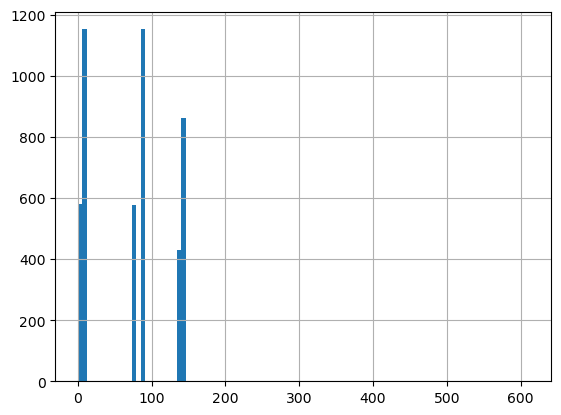

In [148]:
# Merge clinical features with rad features using SubjectID.
data = clinic_features.merge(rad_features, on='SubjectID')

data = data.replace('Not Available', np.nan)

data.isna().sum(axis=0).hist(bins=100)

# Turn into categorical.
for column in data.columns:
    if data[column].dtype == object and column not in ['Survival_from_surgery_days', 'SubjectID']:
        print(column)
        data[column] = pd.Categorical(data[column])


In [149]:
# Data for which we have the label.
data_with_survival = data[~data.Survival_from_surgery_days.isna()].copy()

data_with_survival['Survival_from_surgery_days'] = data_with_survival['Survival_from_surgery_days'].astype(int)


In [150]:
# Drop columns above NaN threshold.
NAN_THRESHOLD = 7

nan_percentages = data_with_survival.isna().sum(axis=0).div(len(data_with_survival)).mul(100)
nan_columns = data_with_survival.isna()



data_with_survival = data_with_survival.drop(columns=nan_percentages[nan_percentages.ge(NAN_THRESHOLD)].index)
len(data_with_survival.columns)



1735

In [151]:
#display(nan_columns)

In [152]:
from pandas.api.types import is_numeric_dtype

# You need to check if it makes sense to fill with the average (also check for outliers).
# Fill NaN with average or majority.
for column in data_with_survival.columns:
    if column in ['SubjectID']:
        continue
        
    if is_numeric_dtype(data_with_survival[column]):
        data_with_survival[column] = data_with_survival[column].fillna(data_with_survival[column].mean())
    else:
        filled_column = data_with_survival[column].fillna(data_with_survival[column].mode())
        
        #One-hot encoding of categorical.
        one_hot = pd.get_dummies(filled_column)
        one_hot.columns = [column + '_' + c for c in one_hot.columns]
        data_with_survival = data_with_survival.join(one_hot).drop(columns=[column])


###  _____________________________________________________________________________________

# Data visualization

- Data exploring and visualization to get an overview of the composition and content of the datasets

In [153]:
clinic_features = pd.read_csv("./Project_UPENN/clinFeatures_UPENN.csv")
display(clinic_features.head(5))

,SubjectID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


In [154]:
# Definition of output pathway
path_output = "/Users/andreasantoro/Library/CloudStorage/OneDrive-ETHZurich/ETH/FS23/Foundamental of Data Science/Project/output/"

In [155]:
#Creating a new column "Death/Alive"; 
# if "Survival_from_surgery_days" != "Not available"; then patient is ALIVE
# We assume that if the data of death is not available, the patient is still alive

try:
    outcome = []
    for i in clinic_features.index:
        if clinic_features.iloc[i, 3] == "Not Available":
            outcome.append("Alive")
        else: 
            outcome.append("Dead")
    clinic_features.insert(4, column= "Outcome", value=outcome)
except:
    print("Column 'Outcome' already exists")
    
display(clinic_features.dtypes)

SubjectID                      object
Gender                         object
Age_at_scan_years             float64
Survival_from_surgery_days     object
Outcome                        object
IDH1                           object
MGMT                           object
KPS                            object
GTR_over90percent              object
Time_since_baseline_preop       int64
PsP_TP_score                  float64
dtype: object

In [156]:
clinic_features_dead = clinic_features[clinic_features['Survival_from_surgery_days'] != 'Not Available']
clinic_features_dead['Survival_from_surgery_days'] = clinic_features_dead['Survival_from_surgery_days'].astype(int)
clinic_features_dead['Survival from surgery [years]'] = clinic_features_dead['Survival_from_surgery_days']/365

#Dataframe with counts for IDH1 and MGMT variants
IDH1_categories = pd.DataFrame(clinic_features_dead['IDH1'].value_counts())
MGMT_categories = pd.DataFrame(clinic_features_dead['MGMT'].value_counts())
#Dataframe with counts for Outcome
clinic_features_outcome = pd.DataFrame(clinic_features['Outcome'].value_counts())

print(clinic_features_outcome)

       Outcome
Dead       452
Alive      159


In [157]:
display(IDH1_categories.iloc[:, 0])

Wildtype    378
NOS/NEC      69
Mutated       5
Name: IDH1, dtype: int64

In [158]:
display(MGMT_categories.iloc[:, 0])

Not Available    217
Unmethylated     139
Methylated        74
Indeterminate     22
Name: MGMT, dtype: int64

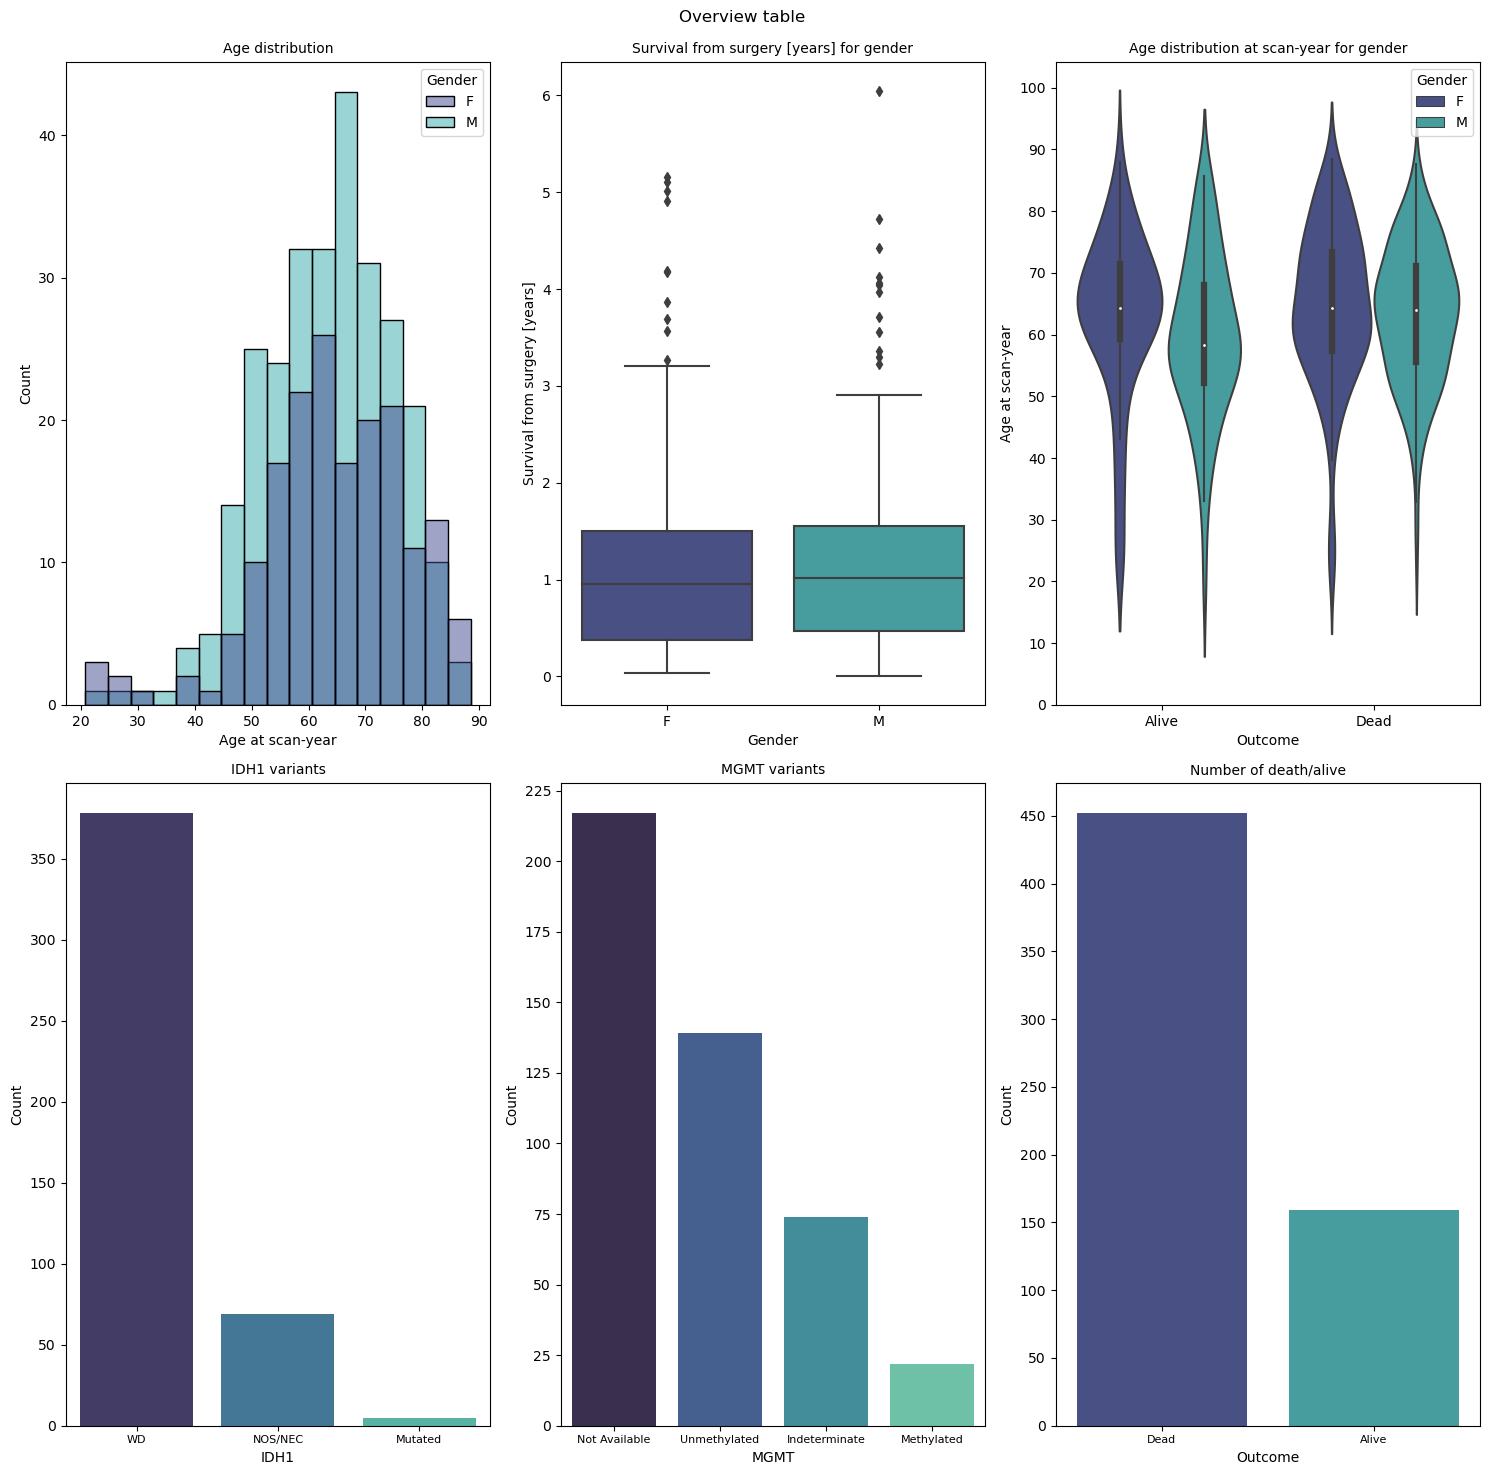

In [250]:
#Data visualization

fig, axs = plt.subplots(2,3, figsize=(15,15))
plt.subplots_adjust(hspace=0.8) 

sns.histplot( data= clinic_features_dead, x = 'Age_at_scan_years', hue = 'Gender', ax=axs[0,0], palette = 'mako')
axs[0,0].set_xlabel(xlabel = 'Age at scan-year')
axs[0,0].set_title(label = 'Age distribution', fontsize = 10)

sns.boxplot(data=clinic_features_dead, x ='Gender', y = 'Survival from surgery [years]', ax = axs[0,1],palette="mako")
axs[0,1].set_xlabel(xlabel = 'Gender')
axs[0,1].set_title(label = 'Survival from surgery [years] for gender', fontsize = 10)

sns.violinplot(data=clinic_features, x ='Outcome', y = 'Age_at_scan_years', hue = 'Gender', ax = axs[0,2], palette="mako")
axs[0,2].set_xlabel(xlabel = 'Outcome')
axs[0,2].set_ylabel(ylabel = 'Age at scan-year')
axs[0,2].set_yticks(ticks = [i for i in range(0, 110, 10)])
axs[0,2].set_title(label = 'Age distribution at scan-year for gender', fontsize = 10)

sns.barplot(data= IDH1_categories, x = IDH1_categories.index,  y = IDH1_categories.iloc[:,0],  ax = axs[1,0], palette="mako")
axs[1,0].set_xticklabels(labels = ['WD', 'NOS/NEC', 'Mutated'], fontsize = 8)
axs[1,0].set_xlabel(xlabel = 'IDH1')
axs[1,0].set_ylabel(ylabel = 'Count')
axs[1,0].set_title(label = 'IDH1 variants', fontsize = 10)

sns.barplot(data=MGMT_categories, x= MGMT_categories.index, y=MGMT_categories.iloc[:,0], ax = axs[1,1], palette="mako")
axs[1,1].set_xticklabels(labels = ['Not Available', 'Unmethylated', 'Indeterminate', 'Methylated'], fontsize = 8, rotation = 0)
axs[1,1].set_xlabel(xlabel = 'MGMT')
axs[1,1].set_ylabel(ylabel = 'Count')
axs[1,1].set_yticks(ticks = [i for i in range(0, 250, 25)])
axs[1,1].set_title(label = 'MGMT variants', fontsize = 10)

sns.barplot(data=clinic_features_outcome, x=clinic_features_outcome.index, y=clinic_features_outcome.iloc[:,0], ax=axs[1,2], palette="mako" )
axs[1,2].set_xticklabels(labels = ['Dead', 'Alive'], fontsize = 8)
axs[1,2].set_xlabel(xlabel = 'Outcome')
axs[1,2].set_ylabel(ylabel = 'Count')
axs[1,2].set_yticks(ticks = [i for i in range(0, 500, 50)])
axs[1,2].set_title(label = 'Number of death/alive', fontsize = 10)


plt.suptitle('Overview table \n')
plt.tight_layout()
plt.savefig(f"{path_output}overviewtables.png", dpi = 1000)


###  _____________________________________________________________________________________

# Linear Regression
- definition of functions needed
- Model fit
- Model evaluation
- results visualization

Definiton of functions needed

In [160]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

def drop_zero_var(data, threshold):
    var = data.var()
    counter = 0
    deleted_col = []
    columns = data.columns.tolist()

    for i in columns:
        if data[i].dtype != 'object':
            if var[i] <= threshold:
                deleted_col.append(i)
                counter += 1

    #print(f"{counter} features found with var ≤ threshold = {threshold}")

    return deleted_col

### Linear regression model fit

In [161]:
# Linear Regression Model
X = data_with_survival.drop(columns=['Survival_from_surgery_days', 'SubjectID']).to_numpy()
y = data_with_survival['Survival_from_surgery_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train, X_test, y_train, y_test = (
    np.array(X_train),
    np.array(X_test),
    np.array(y_train),
    np.array(y_test),)

LR = LinearRegression()
reg = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
coef = LR.coef_
inter = LR.intercept_

### Evaluation

In [162]:
# Evalutation of Linear Regression
r2score = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R2 score: {:.3f}, RMSE: {:.3f}, MAE: {:.3f}".format(abs(r2score), rmse, mae))
print('Coefficient of linear Regression: {}'.format(coef))
print('Intercept of linear Regression:{}'.format(inter))

R2 score: 2.782, RMSE: 500321.440, MAE: 530.361
Coefficient of linear Regression: [-74.04430497   0.17191408 -10.43053427 ...  39.93788091 -12.33037607
  45.56466195]
Intercept of linear Regression:412.3296398891974


### Results visualization

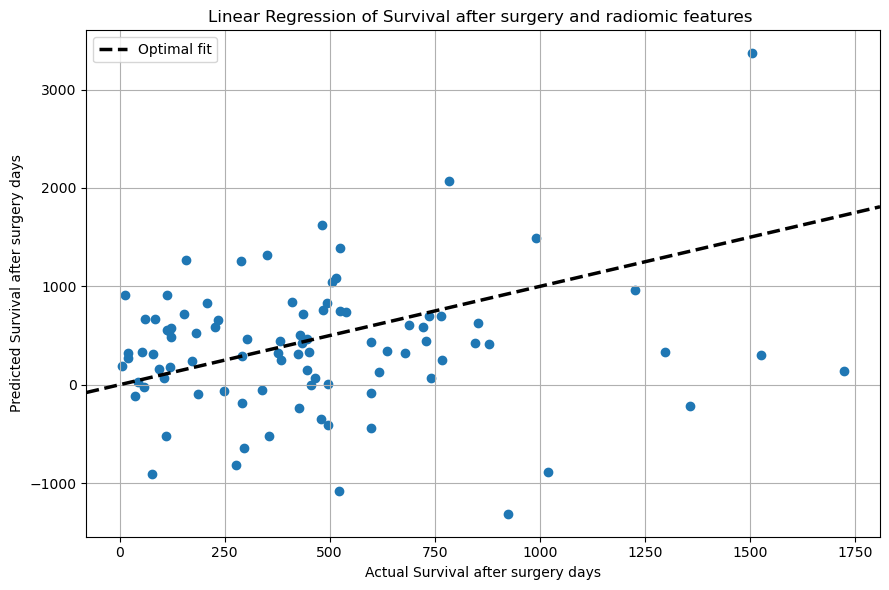

In [163]:
#Plot of Linear Regression
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(y_test, y_pred)
ax.set(xlabel='Actual Survival after surgery days', ylabel='Predicted Survival after surgery days' , title='Linear Regression of Survival after surgery and radiomic features ' )
add_identity(ax, linestyle='--', color='black', linewidth=2.5, label='Optimal fit')
ax.legend()
plt.grid()
plt.tight_layout()

#Save plot
#plt.savefig("../output/LinearRegression.png", dpi=100)
plt.show()

# Logistic Regression



### Classification

In [164]:
# Select only the numerical columns from the DataFrame
numerical_columns = data_with_survival.select_dtypes(include=np.number).columns
X = data_with_survival[numerical_columns]

# Drop the columns you don't need
columns_to_drop = ['Survival_from_surgery_days']
X = X.drop(columns=columns_to_drop)
y = data_with_survival['Survival_from_surgery_days'] > 350
# Define the target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("training set: {}, test set: {}".format(X_train.shape[0], X_test.shape[0]))

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

log_reg = LogisticRegression(penalty='none', random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

training set: 361, test set: 91


In [165]:
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

print("Performance of the logistic regression model:")
print(
    "Accuracy: {:.3f}; Precision: {:.3f}; Recall: {:.3f}; F1 score: {:.3f}".format(
        accuracy, precision, recall, f1
    )
)

Performance of the logistic regression model:
Accuracy: 0.527; Precision: 0.612; Recall: 0.556; F1 score: 0.583


In [166]:
coefficients = log_reg.coef_
importance = np.abs(coefficients)
# Normalize the absolute coefficients to obtain feature importance scores
importance_scores = (importance / np.sum(importance)).flatten()

### Evaluation

In [167]:
# Initialize a 5 fold cross-validator and model, set the random_state to 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Metrics to store the results
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_importance = pd.DataFrame(index=range(1, 6), columns=X.columns)
# Evaluate the model using 5-fold cross-validation

fold = 1
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the data
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # Train and predict
    log_reg.fit(X_train_std, y_train)
    y_pred = log_reg.predict(X_test_std)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the metrics
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    
    # Calculate feature importance
    coefficients = log_reg.coef_
    importance = np.abs(coefficients)
    importance_scores = (importance / np.sum(importance))
    all_importance.loc[fold] = importance_scores
    
    fold += 1
    

# Calculate mean and std of the metrics
mean_metrics = {key: np.mean(values) for key, values in metrics.items()}
std_metrics = {key: np.std(values) for key, values in metrics.items()}

# Print mean and std
for key, value in mean_metrics.items():
    print('{}: {:.3f} ± {:.3f}'.format(key.capitalize(), value, std_metrics[key]))

Accuracy: 0.609 ± 0.039
Precision: 0.627 ± 0.035
Recall: 0.634 ± 0.065
F1: 0.629 ± 0.043


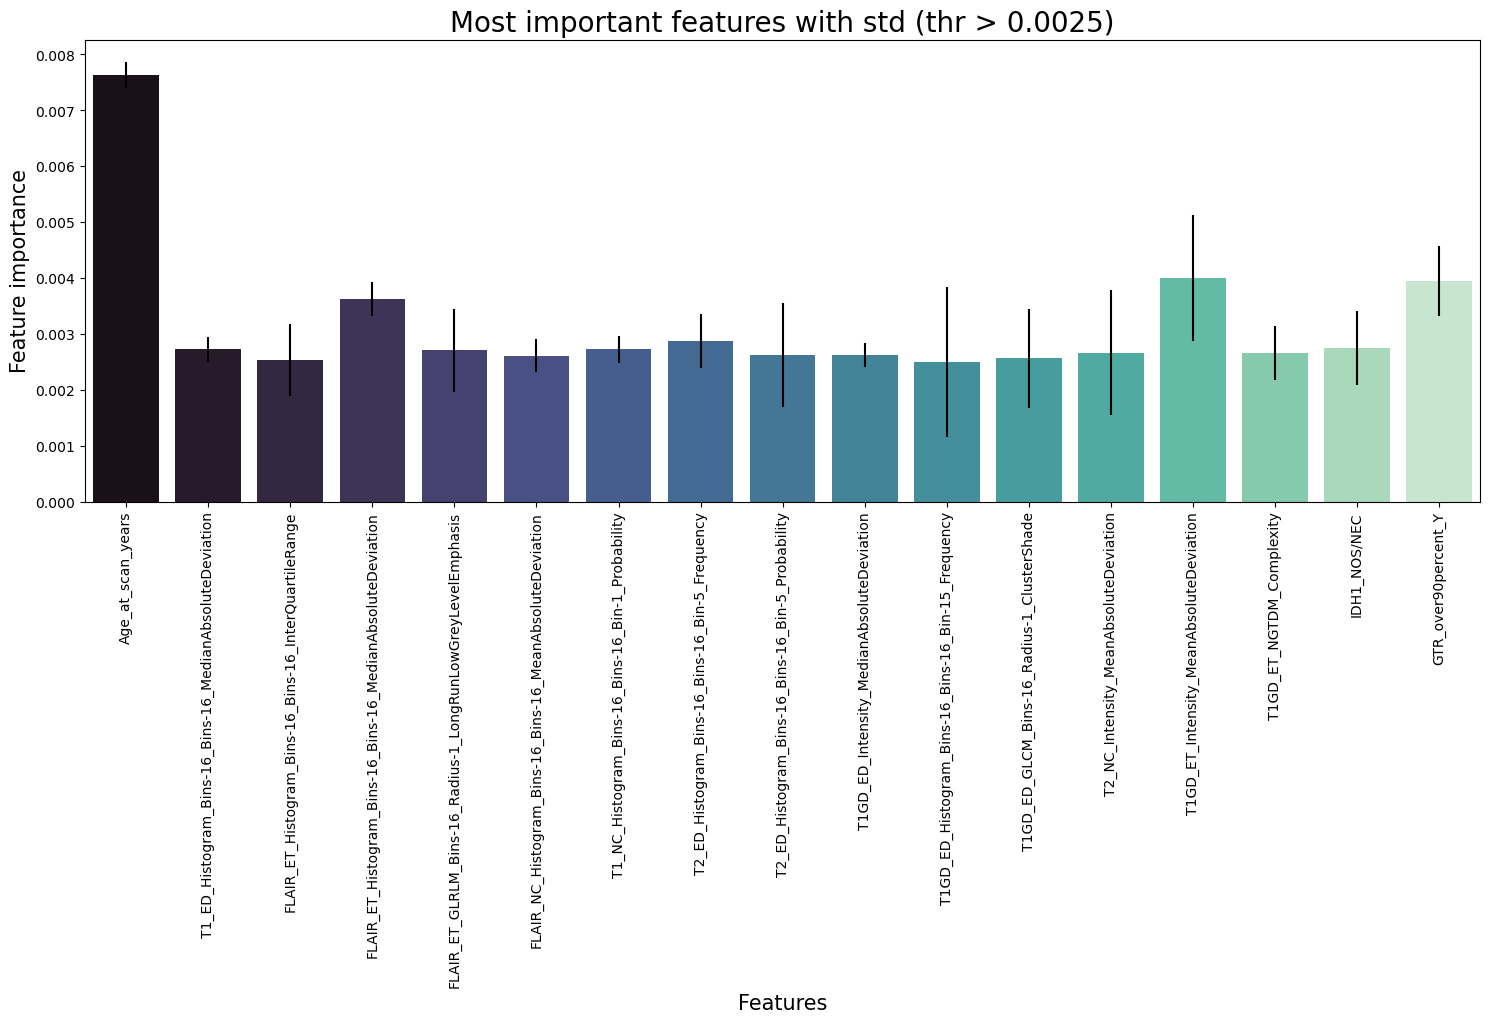

In [169]:
fig, ax = plt.subplots(figsize=(18, 6))

relevant_columns = all_importance.columns[all_importance.mean() > threshold]
#print(all_importance.columns[all_importance.mean() > 0.0025])

means = []
indeces =[]
std = []
threshold = 0.0025
for i in all_importance.columns:
       if all_importance[i].values.mean() > threshold:
        means.append(all_importance[i].values.mean())
        std.append(all_importance[i].values.std())
        indeces.append(i)

all_importance_means = pd.DataFrame(data = means , columns=['Means'], index = indeces)
all_importance_means['Std'] = std

sns.barplot(data = all_importance_means, y = 'Means', x = all_importance_means.index, yerr= all_importance_means['Std'], palette = 'mako')

"""
ax.bar(np.arange(len(relevant_columns)), all_importance[relevant_columns].mean().sort_values(ascending=False) ,
       yerr=all_importance[relevant_columns].std(), palette = 'mako')
"""

ax.set_xticks(np.arange(len(relevant_columns)))
ax.set_xticklabels(relevant_columns, rotation=90)
ax.set_xlabel(xlabel = 'Features', fontsize=15)
ax.set_ylabel(ylabel = 'Feature importance', fontsize=15)


ax.set_title("Most important features with std (thr > 0.0025)", fontsize=20)
plt.savefig(f"{path_output}featLR.png", dpi = 1000)


###  _____________________________________________________________________________________

# Random Forest

### Classification

In [170]:
clf = RandomForestClassifier(n_estimators=100)

X = data_with_survival.drop(columns=['Survival_from_surgery_days', 'SubjectID']).to_numpy()
y = data_with_survival['Survival_from_surgery_days'] > 400

print('Accuracy with all features:', np.mean(cross_val_score(clf, X, y, cv=5, scoring='accuracy')))

# Curse of dimensionality, see: https://en.wikipedia.org/wiki/Curse_of_dimensionality
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, n_features_to_select=100, step=5)
selector = selector.fit(X, y)

X_selected = X[:, selector.get_support()]

print('Accuracy with feature selection:', np.mean(cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')))

# Classification (convert survival to classes): https://link.springer.com/article/10.1007/s11517-019-01986-z
# Example of classification with feature selection: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8507924/
# Another example: https://www.sciencedirect.com/science/article/abs/pii/S0960740418301002
# Literature review: https://www.mdpi.com/2075-4418/12/9/2125


Accuracy with all features: 0.6127228327228328
Accuracy with feature selection: 0.6901831501831502


Definition of funtions needed

In [171]:
# 2. Implement common evaluation metrics 
def get_confusion_matrix(y,y_pred):
    """
    compute the confusion matrix of a classifier yielding
    predictions y_pred for the true class labels y
    :param y: true class labels
    :type y: numpy array

    :param y_pred: predicted class labels
    :type y_pred: numpy array

    :return: comfusion matrix comprising the
             true positives (tp),
             true negatives  (tn),
             false positives (fp),
             and false negatives (fn)
    :rtype: four integers
    """

    # true/false pos/neg.
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    # define positive and negative classes.
    pos = 1
    neg = 0
    for i in range(0, len(y)):
        if y[i] == pos:
            # positive class.
            if y_pred[i] == pos:
                tp += 1
            else:
                fn += 1
        else:
            # negative class.
            if y_pred[i] == neg:
                tn += 1
            else:
                fp += 1
    return tn, fp, fn, tp

In [172]:
def evaluation_metrics(clf, y, X, ax,legend_entry='my legendEntry'):
    """
    compute multiple evaluation metrics for the provided classifier given the true labels
    and input features. Provides a plot of the roc curve on the given axis with the legend
    entry for this plot being specified, too.

    :param clf: true class labels
    :type clf: numpy array

    :param y: true class labels
    :type y: numpy array

    :param X: feature matrix
    :type X: numpy array

    :param ax: matplotlib axis to plot on
    :type legend_entry: matplotlib Axes

    :param legend_entry: the legend entry that should be displayed on the plot
    :type legend_entry: string

    :return: comfusion matrix comprising the
             true positives (tp),
             true negatives  (tn),
             false positives (fp),
             and false negatives (fn)
    :rtype: four integers
    """

    # Get the label predictions
    y_test_pred    = clf.predict(X)

    # Calculate the confusion matrix given the predicted and true labels with your function
    tn, fp, fn, tp = get_confusion_matrix(y, y_test_pred)

    # Ensure that you get correct values - this code will divert to
    # sklearn if your implementation fails - you can ignore those lines
    tn_sk, fp_sk, fn_sk, tp_sk = confusion_matrix(y, y_test_pred).ravel()
    if np.sum([np.abs(tp-tp_sk) + np.abs(tn-tn_sk) + np.abs(fp-fp_sk) + np.abs(fn-fn_sk)]) >0:
        print('OWN confusion matrix failed!!! Reverting to sklearn.')
        tn = tn_sk
        tp = tp_sk
        fn = fn_sk
        fp = fp_sk
    else:
        print(':) Successfully implemented the confusion matrix!')

    # Calculate the evaluation metrics
    # Here you may get an error if the denominator is zero. 
    # Exceptions should be used to handle this but here we show the minimal acceptable solution
    precision   = tp / (tp + fp)
    specificity = tn / (tn + fp)
    accuracy    = (tp + tn) / (tp + fp + tn + fn)
    recall      = tp / (tp + fn)
    f1          = tp/(tp + 0.5*(fp+fn))

    # Get the roc curve using a sklearn function
    y_test_predict_proba  = clf.predict_proba(X)[:, 1]
    fp_rates, tp_rates, _ = roc_curve(y, y_test_predict_proba)

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    # Plot on the provided axis
    ax.plot(fp_rates, tp_rates,label = legend_entry)


    return [accuracy,precision,recall,specificity,f1, roc_auc]

Model fit, evaluation and visualization

:) Successfully implemented the confusion matrix!
:) Successfully implemented the confusion matrix!
:) Successfully implemented the confusion matrix!
:) Successfully implemented the confusion matrix!
:) Successfully implemented the confusion matrix!


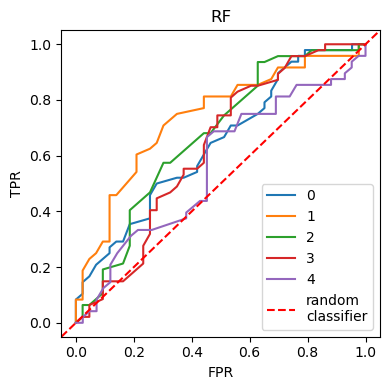

In [173]:
# Select only the numerical columns from the DataFrame
numerical_columns = data_with_survival.select_dtypes(include=np.number).columns
X = data_with_survival[numerical_columns]

# Drop the columns you don't need
columns_to_drop = ['Survival_from_surgery_days']
X = X.drop(columns=columns_to_drop)
y = (data_with_survival['Survival_from_surgery_days'] > 350).astype(int)

n_splits = 5
skf      = StratifiedKFold(n_splits=n_splits)


# Prepare the performance overview data frame
df_performance = pd.DataFrame(columns = ['fold','clf','accuracy','precision','recall',
                                         'specificity','F1','roc_auc'])

# Use this counter to save your performance metrics for each crossvalidation fold
# also plot the roc curve for each model and fold into a joint subplot
fold = 0
fig,ax = plt.subplots(figsize=(4, 4))


# Loop over all splits
for train_index, test_index in skf.split(X, y):

    # Get the relevant subsets for training and testing
    X_test  = X.iloc[test_index].to_numpy()
    y_test  = y.iloc[test_index].to_numpy()
    X_train = X.iloc[train_index].to_numpy()
    y_train = y.iloc[train_index].to_numpy()


    # Standardize the numerical features using training set statistics
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc  = sc.transform(X_test)


    # Creat prediction models and fit them to the training data

    # Random forest
    clf2 = RandomForestClassifier(random_state=1)
    clf2.fit(X_train_sc, y_train)


    # Evaluate your classifiers

    eval_metrics_RF = evaluation_metrics(clf2, y_test, X_test_sc, ax,legend_entry=str(fold))
    df_performance.loc[len(df_performance)-1, :] = [fold, 'RF'] + eval_metrics_RF

    # increase counter for folds
    fold += 1
    
    
# Make plot pretty
model_names = ['LR','RF']
#for i,ax in enumerate(axs):
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
add_identity(ax, color="r", ls="--",label = 'random\nclassifier')
ax.legend()
ax.title.set_text('RF')
plt.tight_layout()

In [174]:
df_performance

,fold,clf,accuracy,precision,recall,specificity,F1,roc_auc
-1,0,RF,0.593407,0.607843,0.645833,0.534884,0.626263,0.641473
0,1,RF,0.703297,0.705882,0.75,0.651163,0.727273,0.737161
1,2,RF,0.611111,0.615385,0.680851,0.534884,0.646465,0.668234
2,3,RF,0.6,0.612245,0.638298,0.55814,0.625,0.625928
3,4,RF,0.522222,0.55814,0.5,0.547619,0.527473,0.562748


In [175]:
print(df_performance.groupby(by = 'clf').agg(['mean', 'std']))

    fold            accuracy           precision             recall            \
    mean       std      mean       std      mean      std      mean       std   
clf                                                                             
RF   2.0  1.581139  0.606007  0.064626  0.619899  0.05346  0.642996  0.091325   

    specificity                  F1             roc_auc            
           mean       std      mean       std      mean       std  
clf                                                                
RF     0.565338  0.048956  0.630495  0.071209  0.647109  0.063547  


# KMeans Clustering



## Features Selection


 - Delete feature with zero variance

In [176]:
#Defining a function that returns all columns with variance ≤ threshold

def drop_zero_var(data, threshold):
    var = data.var()
    counter = 0
    deleted_col = []
    columns = data.columns.tolist()

    for i in columns:
        if data[i].dtype != 'object':
            if var[i] <= threshold:
                deleted_col.append(i)
                counter += 1

    print(f"{counter} features found with var ≤ threshold = {threshold}")

    return deleted_col


In [177]:
#Defining fucntion to get overview on DataFrame

def summary_df(X):
    return X.shape, X.head(), X.columns, X.info(), X.describe()

In [178]:
#summary_df(data_with_survival)

In [179]:
# Identification and display of the features (=columns) with variance ≤ thr
col_drop = drop_zero_var(data_with_survival.iloc[:,1:], 0.01)
display(col_drop)

542 features found with var ≤ threshold = 0.01


['Time_since_baseline_preop',
 'FLAIR_ED_Intensity_CoefficientOfVariation',
 'FLAIR_ED_Intensity_MeanAbsoluteDeviation',
 'FLAIR_ED_Intensity_QuartileCoefficientOfVariation',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-10_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-11_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-12_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-13_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-14_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-15_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-4_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-5_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-6_Probability',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-7_Probability',
 'FLAIR_ED_Histogram_

In [180]:
# Dropping features with variance ≤ thr funded before
data_drop_var = data_with_survival.drop(labels = col_drop, axis=1)

In [181]:
print(len(data_drop_var.columns))

1197


In [182]:
summary_df(data_drop_var)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452 entries, 1 to 610
Columns: 1197 entries, SubjectID to GTR_over90percent_Y
dtypes: float64(1023), int64(166), object(1), uint8(7)
memory usage: 4.1+ MB


((452, 1197),
              SubjectID  Age_at_scan_years  Survival_from_surgery_days  \
 1   UPENN-GBM-00002_11              61.30                         291   
 5   UPENN-GBM-00006_11              52.99                         626   
 7   UPENN-GBM-00008_11              55.06                         469   
 8   UPENN-GBM-00009_11              69.12                         561   
 10  UPENN-GBM-00011_11              39.61                         798   
 
     FLAIR_ED_Intensity_Energy  FLAIR_ED_Intensity_InterQuartileRange  \
 1                  5059094750                                     50   
 5                  1091787939                                     35   
 7                   985265247                                     23   
 8                  2566615286                                     43   
 10                 2264724737                                     54   
 
     FLAIR_ED_Intensity_Kurtosis  FLAIR_ED_Intensity_Maximum  \
 1                      2.191867    

- Multicollinearity

In [183]:
#Indentification of features with correlation ≤/≥ thr 
#Save features' name and correlation in a 2D - list

# Calculate the correlation matrix with Pearson's coeff
corr_matrix = data_drop_var.iloc[:,1:].corr(method='pearson')

#Identify features with -threshold ≤ corr ≤ threshold
thr = 0.85
correlated_features = []
index = corr_matrix.index.tolist()
columns = corr_matrix.columns.tolist()

for i in index:
    for j in columns:
        if i != j:
            if i != 'SubjectID' and j != 'SubjectID' and i != "Age_at_scan_years" and j != "Age_at_scan_years" and i != 'Survival_from_surgery_days' and j != 'Survival_from_surgery_days':
                corr = corr_matrix.loc[i, j]
                if corr >= thr or corr <= -thr:
                    correlated_features.append((i, j, corr))



In [184]:
#Print example
print(correlated_features[0])

('FLAIR_ED_Intensity_Energy', 'FLAIR_ED_Intensity_Sum', 0.9698728217866848)


In [185]:
#Drop all features with multicollinearity

col_to_drop = []
for i in range(len(correlated_features)):
    col_to_drop.append(correlated_features[i][1])

data_drop_corr = data_drop_var.drop(labels = col_to_drop, axis = 1)

display(data_drop_corr.head(3))
summary_df(data_drop_corr)

,SubjectID,Age_at_scan_years,Survival_from_surgery_days,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,FLAIR_ED_Intensity_Range,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ED_NGTDM_Complexity,T1_ED_Intensity_Maximum,T1_ED_Intensity_Minimum,T1_ED_Intensity_Range,T1_ED_Histogram_Bins-16_Bins-16_InterQuartileRange,T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ED_GLCM_Bins-16_Radius-1_Contrast,T1_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean,T1_ED_NGTDM_Complexity,T1_ET_Intensity_MedianAbsoluteDeviation,T1_ET_Intensity_Minimum,T1_ET_Intensity_Range,T1_ET_Histogram_Bins-16_Bins-16_Bin-14_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-4_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-7_Frequency,T1_ET_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ET_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_ET_GLCM_Bins-16_Radius-1_ClusterProminence,T1_ET_GLCM_Bins-16_Radius-1_ClusterShade,T1_ET_GLCM_Bins-16_Radius-1_Contrast,T1_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ET_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_ET_Intensity_Maximum,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ET_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_NC_Intensity_CoefficientOfVariation,FLAIR_NC_Intensity_Maximum,FLAIR_NC_Intensity_MedianAbsoluteDeviation,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-5_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-6_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterProminence,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_NC_GLCM_Bins-16_Radius-1_Contrast,FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_NC_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_NC_Intensity_Maximum,T1_NC_Intensity_MedianAbsoluteDeviation,T1_NC_Intensity_Minimum,T1_NC_Intensity_Range,T1_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-1_Frequency,T1_NC_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_NC_Histogram_Bins-16_Bins-16_QuartileCoefficientOfVariation,T1_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_NC_GLCM_Bins-16_Radius-1_ClusterProminence,T1_NC_GLCM_Bins-16_Radius-1_ClusterShade,T1_NC_GLCM_Bins-16_Radius-1_Contrast,T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_NC_GLSZM_Bins-16_Radius-1_GreyLeve

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452 entries, 1 to 610
Columns: 188 entries, SubjectID to IDH1_Mutated
dtypes: float64(157), int64(29), object(1), uint8(1)
memory usage: 680.5+ KB


((452, 188),
              SubjectID  Age_at_scan_years  Survival_from_surgery_days  \
 1   UPENN-GBM-00002_11              61.30                         291   
 5   UPENN-GBM-00006_11              52.99                         626   
 7   UPENN-GBM-00008_11              55.06                         469   
 8   UPENN-GBM-00009_11              69.12                         561   
 10  UPENN-GBM-00011_11              39.61                         798   
 
     FLAIR_ED_Intensity_Maximum  FLAIR_ED_Intensity_MedianAbsoluteDeviation  \
 1                          255                                   -0.435854   
 5                          213                                    2.919754   
 7                          244                                    1.811498   
 8                          238                                   -3.625198   
 10                         242                                   -4.292874   
 
     FLAIR_ED_Intensity_Minimum  FLAIR_ED_Intensity_Range  \
 1  

In [186]:
print(len(data_drop_corr.columns))

188


In [187]:
data_drop_corr.columns.tolist()

table = []

for i in data_drop_corr.columns.tolist():
    table.append(f"{i}")
    

table

['SubjectID',
 'Age_at_scan_years',
 'Survival_from_surgery_days',
 'FLAIR_ED_Intensity_Maximum',
 'FLAIR_ED_Intensity_MedianAbsoluteDeviation',
 'FLAIR_ED_Intensity_Minimum',
 'FLAIR_ED_Intensity_Range',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency',
 'FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation',
 'FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade',
 'FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast',
 'FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance',
 'FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy',
 'FLAIR_ED_NGTDM_Complexity',
 'T1_ED_Intensity_Maximum',
 'T1_ED_Intensity_Minimum',
 'T1_ED_Intensity_Range',
 'T1_ED_Histogram_Bins-16_Bins-16_InterQuartileRange',
 'T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation',
 'T1_ED_GLCM_Bins-16_Radius-1_Co

## KMeans

##### Import all packages needed in next section

In [188]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#### Definition of fucntions needed for Kmean clsutering and visualization
- function_PCA: performs Principal Component Analysis on give dataframe and return a 2D-array with PCAs
- scatter_PCA: plot patients in scatter plot with PCA components defined by function_PCA
- apply_kmeans_try: performs KMeans with mutiple clusters to establish optimal number of clusters
- apply_kmeans: performs Kmeans with optimal number of clusters


In [189]:
def function_PCA(data, centroids, components):

    scaler = StandardScaler()
    
    data = data.iloc[:,1:]
    data_scaled = scaler.fit_transform(data)
    centroids = centroids[:,1:]
    centroids_scaled = scaler.fit_transform(centroids)

    pca = PCA(n_components= components) 
    principal_components = pca.fit_transform(data_scaled)
    center_coord = pca.transform(centroids_scaled)

    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    center_coord = pd.DataFrame(data=center_coord, columns=['PC1', 'PC2'])

    return principal_df, center_coord

In [233]:
def scatter_PCA(data, labels, clusters, wcss):

    cluster_labels_plot = [f'cluster {i}' for i in labels]
    hue_order = np.sort(np.unique(cluster_labels_plot))

    #PCA on data
    principal_df, center_coord = function_PCA(data, clusters, 2)
    

    #Definition of figure and plotting
    fig, axs = plt.subplots(1,1, figsize=(10,5))
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Scatter Plot with Cluster Centers')
    
    sns.scatterplot(data= principal_df, x = 'PC1', y = 'PC2', hue = cluster_labels_plot, hue_order = hue_order, s=15)
    sns.scatterplot(data = center_coord, x = 'PC1', y = 'PC2', s =30, color = 'black')
    
    plt.title(f'Kmeans clustering with {len(hue_order)} clusters; WCSS: {wcss:.2f}')
    plt.savefig(f"{path_output}clusters.png", dpi = 1000)

In [191]:
def apply_kmeans_try(X,n_clusters):
    """
    Plots the true classes vs the groups found by kmeans.

    Parameters:
        X (numpy array): The data to be clustered.
        y (numpy array): True classes
        n_clusters (numpy array or list): different number of clusters you want to test stored in the array
    Output:
        labels: lables assigned to each element of X
        score: WCSS score
        centroids: position of clusters centers
   """
    
    sc = StandardScaler()
    centroids = []
    score = []

    X_scaled = sc.fit_transform(X)
    
    for i in n_clusters:
        kmeans = KMeans(n_clusters = i, init='k-means++', n_init = 300, max_iter = 100)
        kmeans.fit(X_scaled)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        kmeans_score = kmeans.inertia_
        unsupervised_score = kmeans_score
        
        centroids.append(cluster_centers)
        
        score.append(unsupervised_score);
        
    return labels, score, centroids

In [254]:
def apply_kmeans(X,n_clusters):
   
    """
    Plots the true classes vs the groups found by kmeans.

    Parameters:
        X (numpy array): The data to be clustered.
        y (numpy array): True classes
        n_clusters (numpy array or list): different number of clusters you want to test stored in the array
    Output:
        labels: lables assigned to each element of X
        score: WCSS score
        centroids: position of clusters centers
   """
    
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)
    
    
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init = 300, max_iter = 100)
    kmeans.fit(X_scaled)
    
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    kmeans_score = kmeans.inertia_
    unsupervised_score = kmeans_score

    scatter_PCA(data = X,labels= labels, clusters=cluster_centers, wcss=unsupervised_score)

    return labels, unsupervised_score, cluster_centers

#### Kmeans Clustering
- find optimal number of clusters with apply_kmeans_try and Elbow-plot
- Kmeans with optimal number of clusters
- visualization of clustering on scatter Plot

In [193]:
kmeans_data = data_drop_corr.iloc[:,1:]

In [194]:
print(len(kmeans_data.columns))

187


Find optimal number of clusters with apply_kmeans_try and Elbow-plot

In [195]:
clusters = [i for i in range(2, 50, 1)]
labels_try, wcss_try, centroid_df_try = apply_kmeans_try(kmeans_data, clusters)

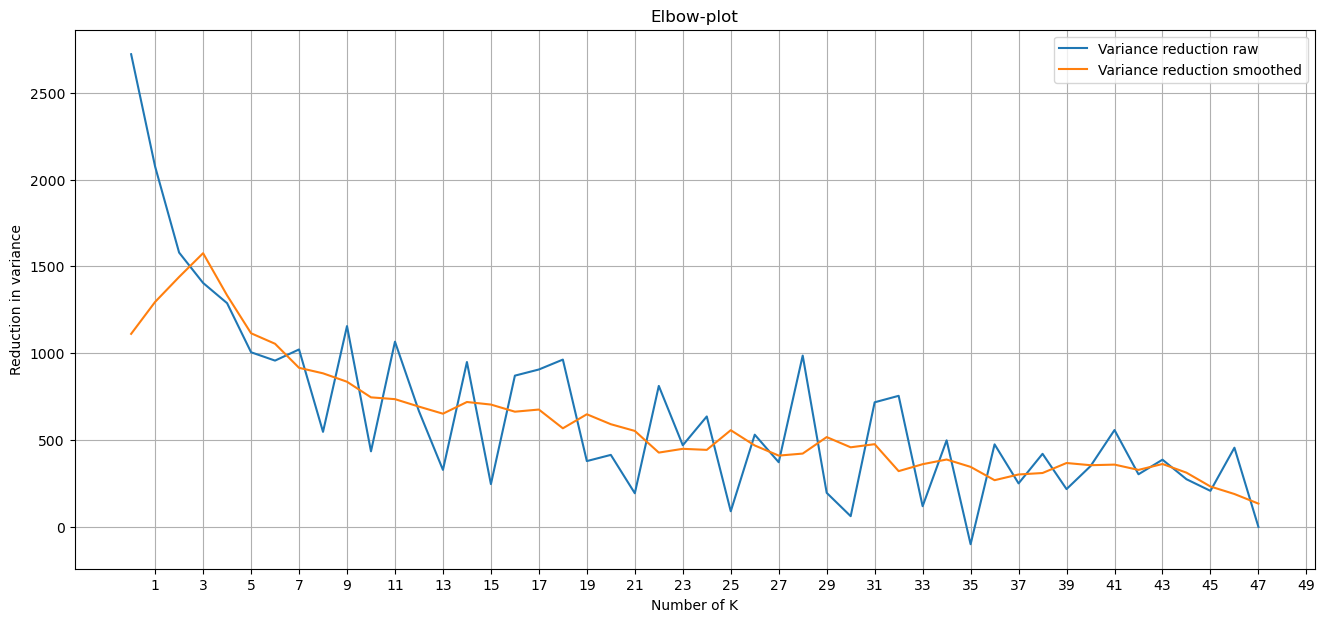

In [252]:
#ELBOW PLOT

fig, axs = plt.subplots(1, 1, figsize = (16, 7))

axs.set_title("Elbow-plot")
axs.set_xlabel("Number of K")
axs.set_ylabel("Reduction in variance")
#axs.set_xlim(left=1, right = 10)
axs.grid(visible=True,  which="both", axis="both")
axs.set_xticks([i for i in range(1, 100, 2)])

reduction_var = [0 for i in range(0, len(wcss_try))]
for i in range(0, len(wcss_try)-1):
    reduction_var[i] = wcss_try[i]-  wcss_try[i+1] 

window_size = 7
smoothed_reduction_var = np.convolve(reduction_var, np.ones(window_size) / window_size, mode='same')

plt.plot(reduction_var, label = 'Variance reduction raw')
plt.plot(smoothed_reduction_var, label = 'Variance reduction smoothed')
plt.title('Elbow-plot')
plt.legend()
plt.grid(visible=True, which = 'both', axis = 'both')


plt.savefig(f"{path_output}Elbowplot.png", dpi = 900)

Kmeans with optimal number of clusters and 
Visualization of clustering on scatter Plot

In [197]:
kmeans_data.columns

Index(['Age_at_scan_years', 'Survival_from_surgery_days',
       'FLAIR_ED_Intensity_Maximum',
       'FLAIR_ED_Intensity_MedianAbsoluteDeviation',
       'FLAIR_ED_Intensity_Minimum', 'FLAIR_ED_Intensity_Range',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency',
       ...
       'T1GD_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation',
       'T1GD_ET_Histogram_Bins-16_Bins-16_Mode',
       'T1GD_ET_Histogram_Bins-16_Bins-16_TenthPercentile',
       'T1GD_ET_GLCM_Bins-16_Radius-1_ClusterProminence',
       'T1GD_ET_GLCM_Bins-16_Radius-1_ClusterShade',
       'T1GD_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance',
       'T1GD_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy',
       'T1GD_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean',
       'T1GD_ET_NGTDM_Complexity', 'IDH1_Mutated'],
      dtype='object', 

67806.75292867086


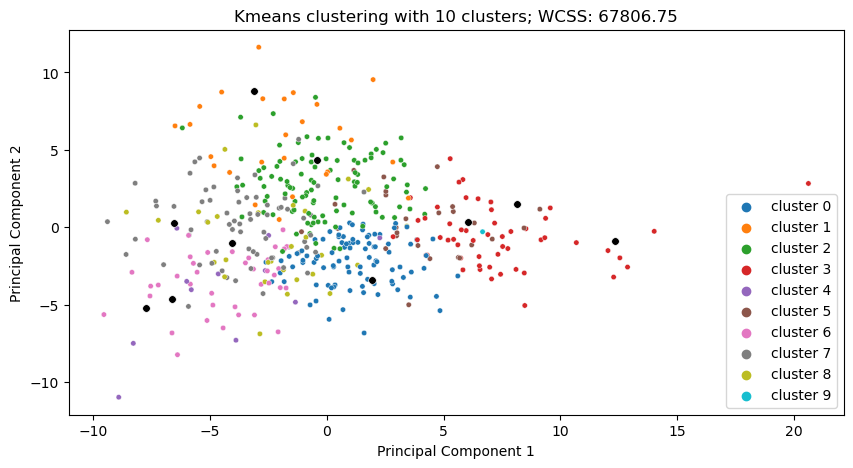

In [255]:
clusters = 10
labels, wcss, centers = apply_kmeans(kmeans_data, clusters)
print(wcss)


In [199]:
#Creation of dataframe with assigned clusters
labels_df = pd.DataFrame(data=labels, columns = ['Cluster'])
display(labels_df.head(3))

,Cluster
0,0
1,1
2,3


In [200]:
#Reset of index
kmeans_data.reset_index(inplace=True, drop=True)
display(kmeans_data.head(3))

,Age_at_scan_years,Survival_from_surgery_days,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,FLAIR_ED_Intensity_Range,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ED_NGTDM_Complexity,T1_ED_Intensity_Maximum,T1_ED_Intensity_Minimum,T1_ED_Intensity_Range,T1_ED_Histogram_Bins-16_Bins-16_InterQuartileRange,T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ED_GLCM_Bins-16_Radius-1_Contrast,T1_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean,T1_ED_NGTDM_Complexity,T1_ET_Intensity_MedianAbsoluteDeviation,T1_ET_Intensity_Minimum,T1_ET_Intensity_Range,T1_ET_Histogram_Bins-16_Bins-16_Bin-14_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-4_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-7_Frequency,T1_ET_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ET_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_ET_GLCM_Bins-16_Radius-1_ClusterProminence,T1_ET_GLCM_Bins-16_Radius-1_ClusterShade,T1_ET_GLCM_Bins-16_Radius-1_Contrast,T1_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ET_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_ET_Intensity_Maximum,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ET_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_NC_Intensity_CoefficientOfVariation,FLAIR_NC_Intensity_Maximum,FLAIR_NC_Intensity_MedianAbsoluteDeviation,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-5_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-6_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterProminence,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_NC_GLCM_Bins-16_Radius-1_Contrast,FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_NC_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_NC_Intensity_Maximum,T1_NC_Intensity_MedianAbsoluteDeviation,T1_NC_Intensity_Minimum,T1_NC_Intensity_Range,T1_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-1_Frequency,T1_NC_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_NC_Histogram_Bins-16_Bins-16_QuartileCoefficientOfVariation,T1_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_NC_GLCM_Bins-16_Radius-1_ClusterProminence,T1_NC_GLCM_Bins-16_Radius-1_ClusterShade,T1_NC_GLCM_Bins-16_Radius-1_Contrast,T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,

In [201]:
#Creation of dataframe with features and assigned clusters for each patient
clustered_data = kmeans_data.merge(labels_df,left_index=True, right_index=True )
display(clustered_data.head(3))

,Age_at_scan_years,Survival_from_surgery_days,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,FLAIR_ED_Intensity_Range,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ED_NGTDM_Complexity,T1_ED_Intensity_Maximum,T1_ED_Intensity_Minimum,T1_ED_Intensity_Range,T1_ED_Histogram_Bins-16_Bins-16_InterQuartileRange,T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ED_GLCM_Bins-16_Radius-1_Contrast,T1_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean,T1_ED_NGTDM_Complexity,T1_ET_Intensity_MedianAbsoluteDeviation,T1_ET_Intensity_Minimum,T1_ET_Intensity_Range,T1_ET_Histogram_Bins-16_Bins-16_Bin-14_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-4_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-7_Frequency,T1_ET_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ET_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_ET_GLCM_Bins-16_Radius-1_ClusterProminence,T1_ET_GLCM_Bins-16_Radius-1_ClusterShade,T1_ET_GLCM_Bins-16_Radius-1_Contrast,T1_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ET_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_ET_Intensity_Maximum,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ET_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_NC_Intensity_CoefficientOfVariation,FLAIR_NC_Intensity_Maximum,FLAIR_NC_Intensity_MedianAbsoluteDeviation,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-5_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-6_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterProminence,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_NC_GLCM_Bins-16_Radius-1_Contrast,FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_NC_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_NC_Intensity_Maximum,T1_NC_Intensity_MedianAbsoluteDeviation,T1_NC_Intensity_Minimum,T1_NC_Intensity_Range,T1_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-1_Frequency,T1_NC_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_NC_Histogram_Bins-16_Bins-16_QuartileCoefficientOfVariation,T1_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_NC_GLCM_Bins-16_Radius-1_ClusterProminence,T1_NC_GLCM_Bins-16_Radius-1_ClusterShade,T1_NC_GLCM_Bins-16_Radius-1_Contrast,T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,

##### Detection of most important features for clustering with a classifier

- Use of RandomForest to perform classification on clustered Data to detect most important features 

In [202]:
# Import packages
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from itertools import cycle


In [203]:
#Copy clustered data and split into features and clusters (target)

df = clustered_data.copy()
X  = df.copy().drop(['Cluster', "Age_at_scan_years", "Survival_from_surgery_days", "IDH1_Mutated"], axis = 1)
y  = df['Cluster']

In [204]:
#Visualizatin of the two new DataFrames
display(X.head(3))
display(y.head(5))

,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,FLAIR_ED_Intensity_Range,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency,FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ED_NGTDM_Complexity,T1_ED_Intensity_Maximum,T1_ED_Intensity_Minimum,T1_ED_Intensity_Range,T1_ED_Histogram_Bins-16_Bins-16_InterQuartileRange,T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ED_GLCM_Bins-16_Radius-1_Contrast,T1_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean,T1_ED_NGTDM_Complexity,T1_ET_Intensity_MedianAbsoluteDeviation,T1_ET_Intensity_Minimum,T1_ET_Intensity_Range,T1_ET_Histogram_Bins-16_Bins-16_Bin-14_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-4_Frequency,T1_ET_Histogram_Bins-16_Bins-16_Bin-7_Frequency,T1_ET_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_ET_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_ET_GLCM_Bins-16_Radius-1_ClusterProminence,T1_ET_GLCM_Bins-16_Radius-1_ClusterShade,T1_ET_GLCM_Bins-16_Radius-1_Contrast,T1_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1_ET_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,T1_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_ET_Intensity_Maximum,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-15_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_ET_GLCM_Bins-16_Radius-1_Contrast,FLAIR_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy,FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean,FLAIR_NC_Intensity_CoefficientOfVariation,FLAIR_NC_Intensity_Maximum,FLAIR_NC_Intensity_MedianAbsoluteDeviation,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-2_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-3_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-5_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_Bin-6_Frequency,FLAIR_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,FLAIR_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterProminence,FLAIR_NC_GLCM_Bins-16_Radius-1_ClusterShade,FLAIR_NC_GLCM_Bins-16_Radius-1_Contrast,FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,FLAIR_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,FLAIR_NC_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis,T1_NC_Intensity_Maximum,T1_NC_Intensity_MedianAbsoluteDeviation,T1_NC_Intensity_Minimum,T1_NC_Intensity_Range,T1_NC_Histogram_Bins-16_Bins-16_Bin-0_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-15_Frequency,T1_NC_Histogram_Bins-16_Bins-16_Bin-1_Frequency,T1_NC_Histogram_Bins-16_Bins-16_CoefficientOfVariation,T1_NC_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation,T1_NC_Histogram_Bins-16_Bins-16_QuartileCoefficientOfVariation,T1_NC_GLCM_Bins-16_Radius-1_AutoCorrelation,T1_NC_GLCM_Bins-16_Radius-1_ClusterProminence,T1_NC_GLCM_Bins-16_Radius-1_ClusterShade,T1_NC_GLCM_Bins-16_Radius-1_Contrast,T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis,T1_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance,T1GD_NC_Intensity_MedianAbsoluteDeviation,T1G

0    0
1    1
2    3
3    0
4    0
Name: Cluster, dtype: int32

In [205]:
def evaluation_metrics(clf, y, X):
    """
    Compute multiple evaluation metrics for the provided classifier given the true labels
    and input features.

    :param clf: classifier
    :type clf: sklearn classifier object

    :param y: true class labels
    :type y: numpy array

    :param X: feature matrix
    :type X: numpy array

    :return: list of evaluation metrics
    :rtype: list
    """

    # Get the label predictions
    y_test_pred = clf.predict_proba(X)  # Use predict_proba to get predicted probabilities

    # Convert continuous predictions to discrete class labels
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)

    # Calculate the evaluation metrics
    precision = precision_score(y, y_test_pred_labels, average="macro")
    accuracy = accuracy_score(y, y_test_pred_labels)
    recall = recall_score(y, y_test_pred_labels, average="macro")
    f1 = f1_score(y, y_test_pred_labels, average="macro")


    return [accuracy, precision, recall, f1]


Perform RandomForest classification

In [206]:
# Perform a 5-fold crossvalidation - prepare the splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Prepare the performance overview data frame
df_performance = pd.DataFrame(columns=['fold', 'clf', 'accuracy', 'precision', 'recall', 'F1'])

# Use this counter to save your performance metrics for each crossvalidation fold
# also plot the roc curve for each model and fold into a joint subplot
fold = 0

# Loop over all splits
for train_index, test_index in skf.split(X, y):

    # Get the relevant subsets for training and testing
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]

    # Standardize the numerical features using training set statistics
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)

    # Random forest
    clf2 = RandomForestClassifier(random_state=1)
    clf2.fit(X_train_sc, y_train)

    eval_metrics_RF = evaluation_metrics(clf2, y_test, X_test_sc)
    df_performance.loc[len(df_performance) - 1, :] = [fold, 'RF'] + eval_metrics_RF

    # Increase counter for folds
    fold += 1

Visualization of performance metrics of classifier

     fold  accuracy  precision    recall        F1
clf                                               
RF    2.0   0.70801   0.607334  0.548369  0.560459
         fold  accuracy  precision    recall        F1
clf                                                   
RF   1.581139  0.015683   0.093863  0.049436  0.062757


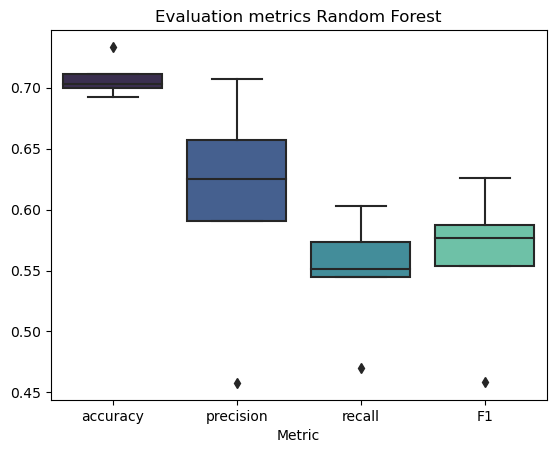

In [256]:
# Summarize the folds
print(df_performance.groupby(by = 'clf').mean())
print(df_performance.groupby(by = 'clf').std())

sns.boxplot(data = df_performance.iloc[:, 1:], palette = "mako")
plt.title("Evaluation metrics Random Forest")
plt.xlabel("Metric")

plt.savefig(f"{path_output}evaluationmetricsRF.png", dpi = 500)


Most important features

In [208]:
importances = clf2.feature_importances_

features_list = X.columns.tolist()
centers_index =[]
indices = np.argsort(importances)[::-1]

for i in range(len(importances)-179):
    print(f"{i+1}. Feature {features_list[indices[i]]}: {importances[indices[i]]}")
    centers_index.append(indices[i])

1. Feature T1GD_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis: 0.029411487778737252
2. Feature T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis: 0.025245421717095703
3. Feature T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis: 0.02158460451974238
4. Feature T1GD_ED_Histogram_Bins-16_Bins-16_Bin-6_Frequency: 0.021361743247578314
5. Feature FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency: 0.01987220902325656


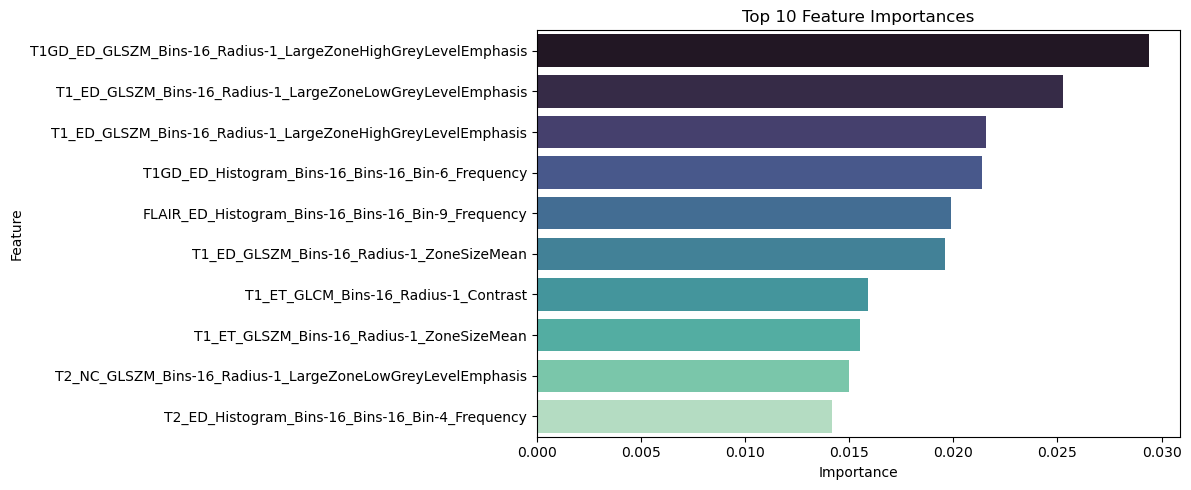

In [259]:
importances = clf2.feature_importances_
features_list = X.columns.tolist()
indices = np.argsort(importances)[::-1]

# Select the first 10 features
top_features = indices[:10]
top_importances = importances[top_features]
top_feature_names = [features_list[i] for i in top_features]

# Create a dataframe for plotting
data = pd.DataFrame({'Feature': top_feature_names, 'Importance': top_importances})

# Sort the dataframe by importance
data.sort_values('Importance', ascending=False, inplace=True)

figg, axxs = plt.subplots(1,1, figsize=(12, 5))

# Plot the feature importances
sns.barplot(data=data, x='Importance', y='Feature', palette = 'mako')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.savefig(f"{path_output}top10feat.png", dpi = 1000)


In [260]:
def scatter_PCA_most_important_feat(first_feat, second_feat, third_feat, fourth_feat, centers_index, data, clusters, wcss, centroids):

    cluster_labels_plot = [f'cluster {i}' for i in clusters]
    hue_order = np.sort(np.unique(cluster_labels_plot))

    center_coord = pd.DataFrame()
    center_coord["PC1"] = centers[:, centers_index[0]]
    center_coord["PC2"] = centers[:, centers_index[1]]
    center_coord["PC3"] = centers[:, centers_index[2]]
    center_coord["PC4"] = centers[:, centers_index[3]]

    principal_df = pd.DataFrame()
    principal_df["PC1"]= data[first_feat]
    principal_df["PC2"]= data[second_feat]
    principal_df["PC3"]= data[third_feat]
    principal_df["PC4"]= data[fourth_feat]
 
    std = StandardScaler()
    principal_df = std.fit_transform(principal_df)
    center_coord = std.fit_transform(center_coord)
    
    pca = PCA(n_components=2)
    principal_df = pca.fit_transform(principal_df)
    center_coord = pca.transform(center_coord)

    display(center_coord)

    fig, axs = plt.subplots(1,1, figsize=(10,10))
   
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Kmeans clustering with {len(hue_order)} clusters; WCSS: {wcss:.2f}')
    plt.ylim(-3, 2.5)
    plt.xlim(-1.3, 2)
    sns.scatterplot(data= principal_df, x = principal_df[:, 0], y = principal_df[:, 1], 
                    hue = cluster_labels_plot, hue_order = hue_order, s=10)
    
    sns.scatterplot(data = center_coord, x = center_coord[:, 0], y = center_coord[:, 1], 
                    s = 20, color = 'black', marker = "x")
    
    centroids_label = center_coord
    for i in range(0, len(centroids_label)):
        if i == 0:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0], centroids_label[i][1]+ 0.17), ha='center', 
                        xycoords="data", annotation_clip = False)
        elif i == 5:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0], centroids_label[i][1]+ 0.15), ha='left', 
                        xycoords="data", annotation_clip = True)
        elif i== 2:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0]+0.2, centroids_label[i][1]), ha='left', 
                        xycoords="data", annotation_clip = False)
        elif i == 6:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0]+ 0.1, centroids_label[i][1]+ 0.07), ha='left', 
                        xycoords="data", annotation_clip = False)
        elif i == 8:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0]- 0.3, centroids_label[i][1]+ 0.07), ha='left', 
                        xycoords="data", annotation_clip = False)
        else:
            plt.annotate(text = f"Cluster {i}", xy= (centroids_label[i][0], centroids_label[i][1]), 
                        xytext= (centroids_label[i][0]+ 0.1, centroids_label[i][1]+ 0.07), ha='left', 
                        xycoords="data", annotation_clip = False)
    
    plt.savefig(f"{path_output}clustersmost.png", dpi = 1000)

    return (first_feat, second_feat, third_feat, fourth_feat)
    

array([[ 0.21464953,  1.45960511],
       [ 1.52001782, -2.53216007],
       [-0.2172599 , -0.6843222 ],
       [ 0.61998063,  1.54282289],
       [-0.88631895, -0.41087445],
       [ 0.42234084,  0.90646077],
       [-0.81312217,  0.36640707],
       [ 0.11596174,  0.57308324],
       [-0.43047375,  0.01879468],
       [-0.54577579, -1.23981705]])

('T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis',
 'T1GD_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis',
 'T1GD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency',
 'T1GD_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency')

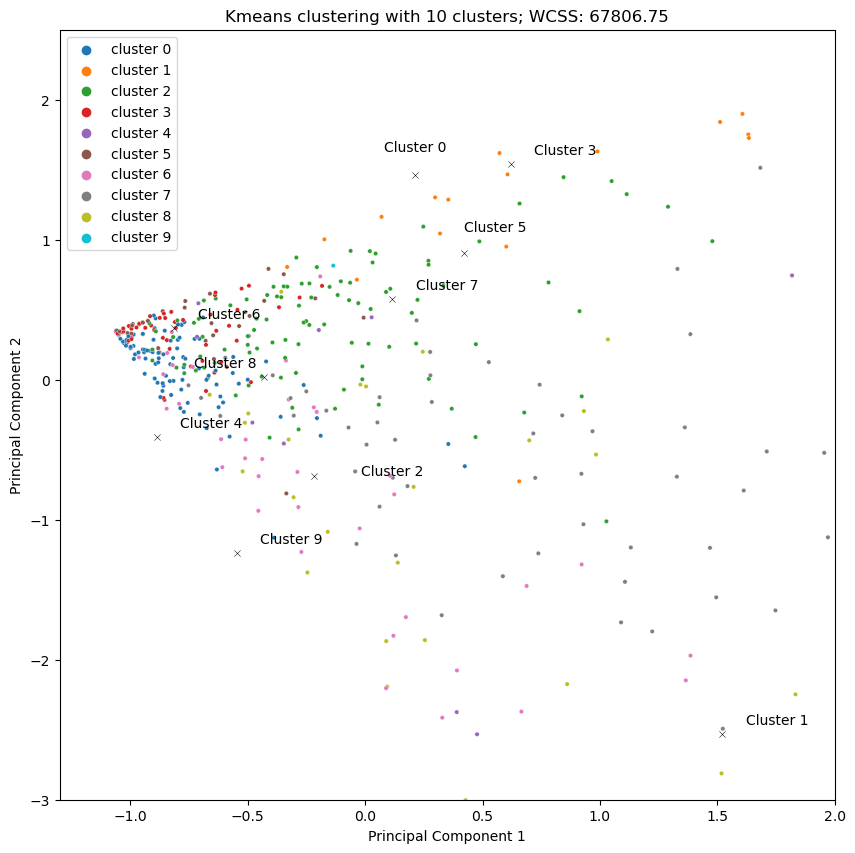

In [261]:
scatter_PCA_most_important_feat("T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis", "T1GD_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis", "T1GD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency","T1GD_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency" ,centers_index, kmeans_data, labels, wcss, centers)

## Results

### Results Visualization

In [212]:
data_drop_corr = data_drop_corr.reset_index(drop = True)
subject_id = data_drop_corr['SubjectID'] #retrieving SubjectIDs from the initial dataset after features selection

clustered_data_clusters = clustered_data['Cluster'] #retrieving Clusters from KMeans
df = [subject_id, clustered_data_clusters] #merging of SubjectIDs and Clusters in a third DataSet

data_heatmap = pd.concat(df, axis=1) #concatanate SubjectIDs and Clusters

clinic_features_genes = clinic_features.loc[:, ['SubjectID','IDH1', 'MGMT']] #retriving genetic information and Subject IDs


In [213]:
display(data_heatmap.head(5))

,SubjectID,Cluster
0,UPENN-GBM-00002_11,0
1,UPENN-GBM-00006_11,1
2,UPENN-GBM-00008_11,3
3,UPENN-GBM-00009_11,0
4,UPENN-GBM-00011_11,0


In [214]:
display(clinic_features_genes.head(5))

,SubjectID,IDH1,MGMT
0,UPENN-GBM-00001_11,Wildtype,Not Available
1,UPENN-GBM-00002_11,Wildtype,Not Available
2,UPENN-GBM-00003_11,Wildtype,Not Available
3,UPENN-GBM-00004_11,NOS/NEC,Not Available
4,UPENN-GBM-00005_11,Wildtype,Not Available


In [215]:
data_results1 = pd.merge(data_heatmap, clinic_features_genes, on = "SubjectID", how = 'outer')

In [216]:
#merging Genetic information, Cluster,selected Radiomic features and SubjectIDs
data_results = pd.merge(data_results1, clinic_features.iloc[:,0:4], on = 'SubjectID', how = 'outer' )

In [217]:
display(data_results.head(5))

,SubjectID,Cluster,IDH1,MGMT,Gender,Age_at_scan_years,Survival_from_surgery_days
0,UPENN-GBM-00002_11,0.0,Wildtype,Not Available,F,61.30,291
1,UPENN-GBM-00006_11,1.0,Wildtype,Not Available,M,52.99,626
2,UPENN-GBM-00008_11,3.0,Wildtype,Not Available,F,55.06,469
3,UPENN-GBM-00009_11,0.0,Wildtype,Not Available,M,69.12,561
4,UPENN-GBM-00011_11,0.0,NOS/NEC,Not Available,F,39.61,798


In [218]:
display(clinic_features.head(5))

,SubjectID,Gender,Age_at_scan_years,Survival_from_surgery_days,Outcome,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Alive,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Dead,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Alive,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,Alive,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Alive,Wildtype,Not Available,Not Available,Y,0,NaN


Visualization of data:
- count of patients in each clusters
- distributions for MGMT and IDH1
- most important features

In [219]:
data_results = data_results.dropna() #dropping NA
data_results["Cluster"] = data_results["Cluster"].astype(int)

In [220]:
display(data_results)

,SubjectID,Cluster,IDH1,MGMT,Gender,Age_at_scan_years,Survival_from_surgery_days
0,UPENN-GBM-00002_11,0,Wildtype,Not Available,F,61.30,291
1,UPENN-GBM-00006_11,1,Wildtype,Not Available,M,52.99,626
2,UPENN-GBM-00008_11,3,Wildtype,Not Available,F,55.06,469
3,UPENN-GBM-00009_11,0,Wildtype,Not Available,M,69.12,561
4,UPENN-GBM-00011_11,0,NOS/NEC,Not Available,F,39.61,798
5,UPENN-GBM-00012_11,4,Wildtype,Not Available,M,53.85,882
6,UPENN-GBM-00013_11,1,NOS/NEC,Not Available,M,69.45,472
7,UPENN-GBM-00014_11,0,Wildtype,Not Available,M,68.06,272
8,UPENN-GBM-00016_11,3,Wildtype,Not Available,M,70.89,509
9,UPENN-GBM-00017_11,3,NOS/NEC,Not Available,M,69.23,1297


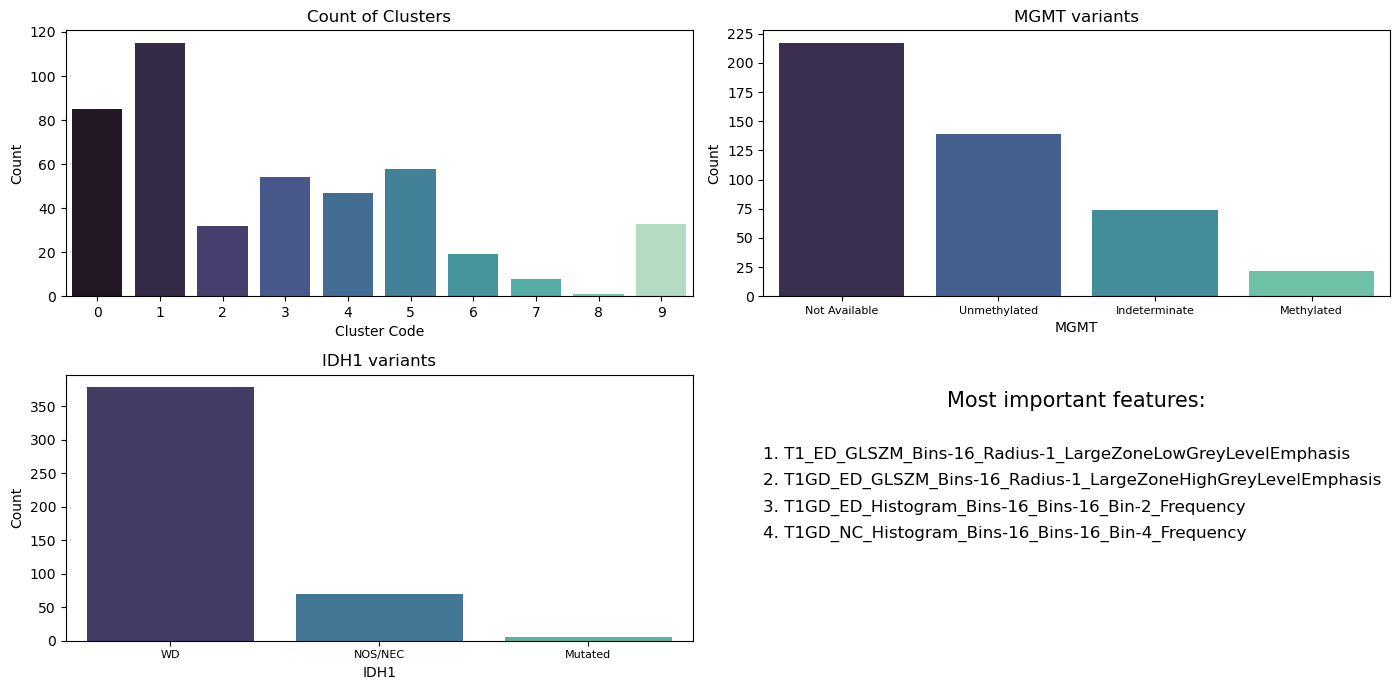

In [262]:
fig2, axs2 = plt.subplots(2,2, figsize=(15,7))

wcss_df = pd.DataFrame(data=reduction_var, columns=['WCSS'])


clusters_count = pd.DataFrame(data = data_results['Cluster'].value_counts())

IDH1_categories = pd.DataFrame(data_results['IDH1'].value_counts())
MGMT_categories = pd.DataFrame(data_results['MGMT'].value_counts())

axs2[1, 1].set_axis_off()
axs2[1, 1].text(0.5, 0.9, "Most important features:", ha='center', va='center', fontsize=15)
axs2[1, 1].text(0, 0.7, "1. T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis", ha='left', va='center', fontsize=12)
axs2[1, 1].text(0, 0.6, "2. T1GD_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis", ha='left', va='center', fontsize=12)
axs2[1, 1].text(0, 0.5, "3. T1GD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency", ha='left', va='center', fontsize=12)
axs2[1, 1].text(0, 0.4, "4. T1GD_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency", ha='left', va='center', fontsize=12)

sns.barplot(data = clusters_count, x = clusters_count.index , y = clusters_count.iloc[:,0],ax = axs2[0,0], palette = 'mako')
axs2[0,0].set_title("Count of Clusters")
axs2[0,0].set_xlabel("Cluster Code")
axs2[0,0].set_ylabel("Count")


sns.barplot(data= IDH1_categories, x = IDH1_categories.index,  y = IDH1_categories.iloc[:,0],  ax = axs2[1,0], palette="mako")
axs2[1,0].set_xticklabels(labels = ['WD', 'NOS/NEC', 'Mutated'], fontsize = 8)
axs2[1,0].set_xlabel(xlabel = 'IDH1')
axs2[1,0].set_ylabel(ylabel = 'Count')
axs2[1,0].set_title(label = 'IDH1 variants')

sns.barplot(data=MGMT_categories, x= MGMT_categories.index, y=MGMT_categories.iloc[:,0], ax = axs2[0,1], palette="mako")
axs2[0,1].set_xticklabels(labels = ['Not Available', 'Unmethylated', 'Indeterminate', 'Methylated'], fontsize = 8, rotation = 0)
axs2[0,1].set_xlabel(xlabel = 'MGMT')
axs2[0,1].set_ylabel(ylabel = 'Count')
axs2[0,1].set_yticks(ticks = [i for i in range(0, 250, 25)])
axs2[0,1].set_title(label = 'MGMT variants')

fig2.tight_layout()
plt.savefig(f"{path_output}resultstable.png", dpi = 1000)




Visualization of cluster counts and most important features

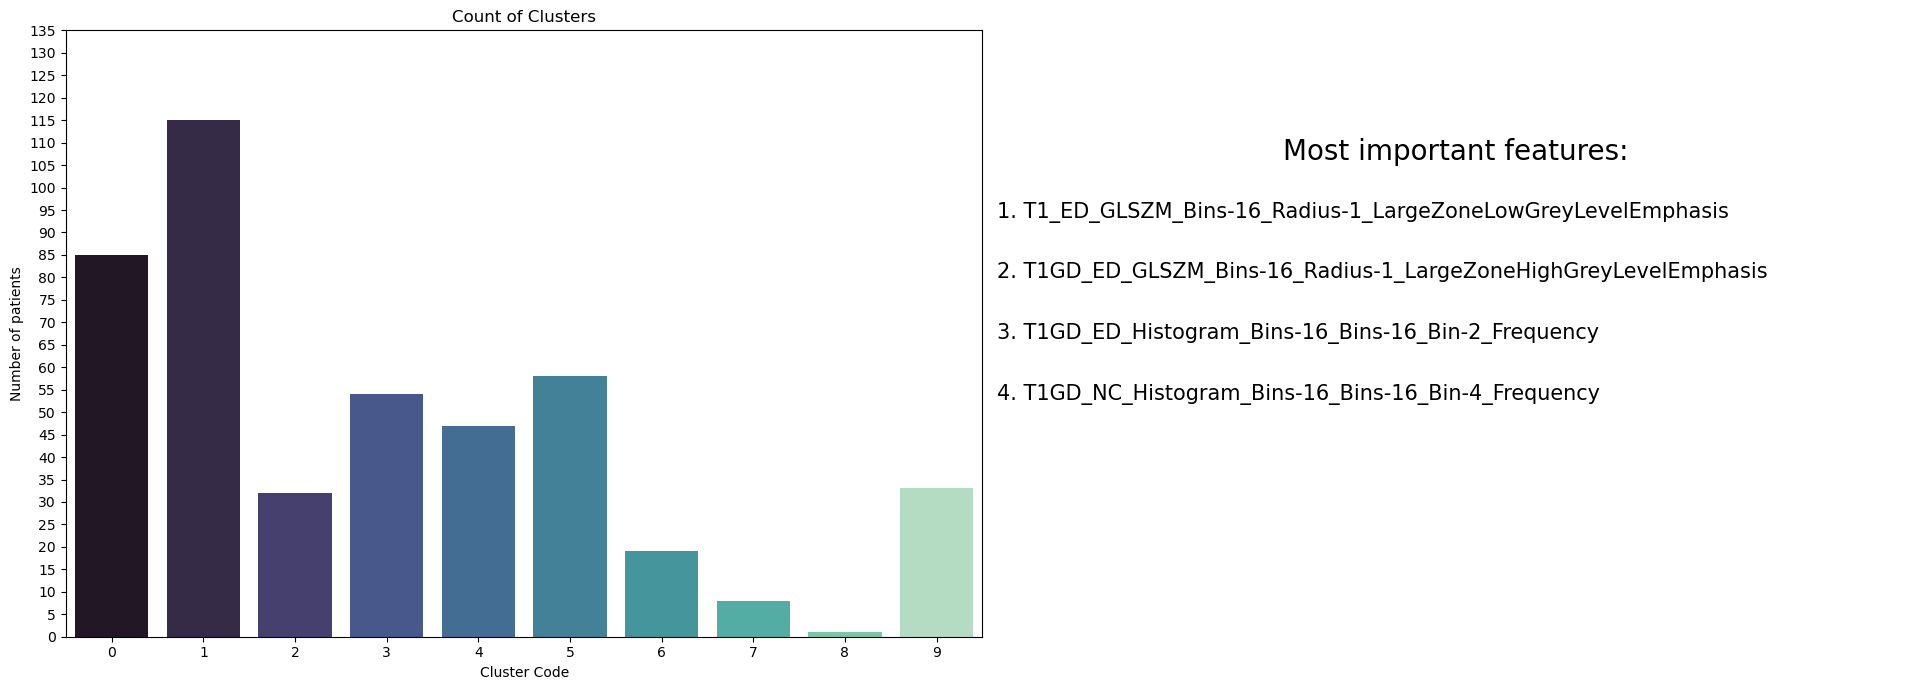

In [263]:
fig2, axs2 = plt.subplots(1, 2, figsize=(20,7))

wcss_df = pd.DataFrame(data=reduction_var, columns=['WCSS'])


clusters_count = pd.DataFrame(data = data_results['Cluster'].value_counts())

axs2[1].set_axis_off()
axs2[1].text(0.5, 0.8, "Most important features:", ha='center', va='center', fontsize=20)
axs2[1].text(0, 0.7, "1. T1_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis", ha='left', va='center', fontsize=15)
axs2[1].text(0, 0.6, "2. T1GD_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis", ha='left', va='center', fontsize=15)
axs2[1].text(0, 0.5, "3. T1GD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency", ha='left', va='center', fontsize=15)
axs2[1].text(0, 0.4, "4. T1GD_NC_Histogram_Bins-16_Bins-16_Bin-4_Frequency", ha='left', va='center', fontsize=15)

sns.barplot(data = clusters_count, x = clusters_count.index , y = clusters_count.iloc[:,0],ax = axs2[0], palette = 'mako')
axs2[0].set_title("Count of Clusters")
axs2[0].set_xlabel("Cluster Code")
axs2[0].set_ylabel("Number of patients")


ticksy = [i for i in range(0, 140, 5)]

axs2[0].set_yticks(ticksy)

fig2.tight_layout()

plt.savefig(f"{path_output}resultstableshort.png", dpi = 1000)




In [223]:
data_results["Cluster"].loc[data_results["MGMT"] == "NOS/NEC"]

Series([], Name: Cluster, dtype: int64)

In [224]:
data_results_try = data_results[data_results.iloc[:,3] != "Not Available"] #selecting only IDH1 different from "Not Available"
data_results_try = data_results_try.dropna() #dropping NA
data_results_try["Survival_from_surgery_days"]=data_results_try["Survival_from_surgery_days"].astype(int) #converting Survival from surgery days from "object" to "int"

In [225]:
display(data_results_try["Cluster"].value_counts())

1    62
0    40
3    29
5    27
4    23
2    22
9    18
6     7
7     6
8     1
Name: Cluster, dtype: int64

### Statistical tests
- Chi-square
- Fisher Test

Chi-square test within same cluster

In [226]:
data_results_try = data_results_try.copy()
data_results_try["Cluster"] = data_results_try["Cluster"].astype(int)

display(data_results_try.head(5))

,SubjectID,Cluster,IDH1,MGMT,Gender,Age_at_scan_years,Survival_from_surgery_days
13,UPENN-GBM-00022_11,0,Wildtype,Unmethylated,F,53.88,1882
19,UPENN-GBM-00034_11,1,Wildtype,Unmethylated,F,53.63,464
36,UPENN-GBM-00068_11,0,Wildtype,Indeterminate,M,52.20,389
43,UPENN-GBM-00078_11,4,Wildtype,Indeterminate,M,70.74,158
46,UPENN-GBM-00082_11,1,Wildtype,Indeterminate,M,44.78,351


In [265]:
import scipy.stats as stats

groups = np.array(data_results_try["Cluster"])     # Sample data
gene_variant = np.array(data_results_try["MGMT"])  # Array of gene variants for each patient

# Create a contingency table
contingency_table = np.zeros((3, 10))
unique_groups = np.unique(groups)
unique_variants = np.unique(gene_variant)

print(unique_groups)

for i, group in enumerate(unique_groups):
    for j, variant in enumerate(unique_variants):
        count = np.sum((groups == group) & (gene_variant == variant))
        contingency_table[j, i] = count

print(contingency_table)

chi2_stat, p_values = stats.chisquare(contingency_table)

print("Chi-square statistic:", chi2_stat)
print("p-value:", p_values)

p_values = p_values.tolist()

[0 1 2 3 4 5 6 7 8 9]
[[ 1.  7.  1.  3.  6.  2.  0.  0.  0.  2.]
 [14. 22.  8.  5.  6. 10.  2.  3.  0.  4.]
 [25. 33. 13. 21. 11. 15.  5.  3.  1. 12.]]
Chi-square statistic: [21.65       16.48387097  9.90909091 20.13793103  2.17391304  9.55555556
  5.42857143  3.          2.          9.33333333]
p-value: [1.98958379e-05 2.63374000e-04 7.05128468e-03 4.23744269e-05
 3.37241320e-01 8.41467749e-03 6.62522592e-02 2.23130160e-01
 3.67879441e-01 9.40356255e-03]


Fisher test between different cluster

In [228]:
num_clusters = data_results_try["Cluster"].nunique()
print(num_clusters)

10


Significant difference in number of patients with Unmethylated form of MGMT between clusters?

In [266]:
from scipy.stats import fisher_exact

gene_interest = 'Unmethylated'
count_per_cluster = data_results_try["Cluster"].loc[data_results_try["MGMT"] == "Unmethylated"].value_counts()

total_number_patient_cluster = data_results_try["Cluster"].value_counts().tolist()

# Number of clusters
num_clusters = 10

print(total_number_patient_cluster)

# Number of patients with the gene of interest in each cluster
gene_counts = count_per_cluster.values.tolist()

# Total number of patients in each cluster
total_counts = total_number_patient_cluster

print(gene_counts)

# Create a contingency table for all clusters
contingency_table_fisher = np.column_stack((gene_counts, np.subtract(total_counts, gene_counts)))


# Perform Fisher's exact test for all clusters
p_values_f = []
odds_ratios = []
for i in range(0, num_clusters):
    odds_ratio, p_value = fisher_exact([contingency_table_fisher[i], contingency_table_fisher.sum(axis=0)])
    p_values_f.append(p_value)
    odds_ratios.append(odds_ratio)

# Print the p-values for all clusters
for i, p_value in enumerate(p_values_f):
    print("Cluster", i, "p-value:", p_value)

for i, odds_ratio in enumerate(odds_ratios):
    print("Cluster", i, "odds ratio", odds_ratio)


[62, 40, 29, 27, 23, 22, 18, 7, 6, 1]
[33, 25, 21, 15, 13, 12, 11, 5, 3, 1]
Cluster 0 p-value: 0.46992295170248594
Cluster 1 p-value: 0.7304712896771117
Cluster 2 p-value: 0.226765136890604
Cluster 3 p-value: 0.8368894781347886
Cluster 4 p-value: 0.8271008861277604
Cluster 5 p-value: 0.8213639590084296
Cluster 6 p-value: 1.0
Cluster 7 p-value: 0.704291221921418
Cluster 8 p-value: 0.6918662062287079
Cluster 9 p-value: 1.0
Cluster 0 odds ratio 0.7859092036715455
Cluster 1 odds ratio 1.1510791366906474
Cluster 2 odds ratio 1.8129496402877698
Cluster 3 odds ratio 0.8633093525179856
Cluster 4 odds ratio 0.897841726618705
Cluster 5 odds ratio 0.8287769784172662
Cluster 6 odds ratio 1.0853031860226106
Cluster 7 odds ratio 1.7266187050359711
Cluster 8 odds ratio 0.6906474820143885
Cluster 9 odds ratio inf


Extensive visualization of results 

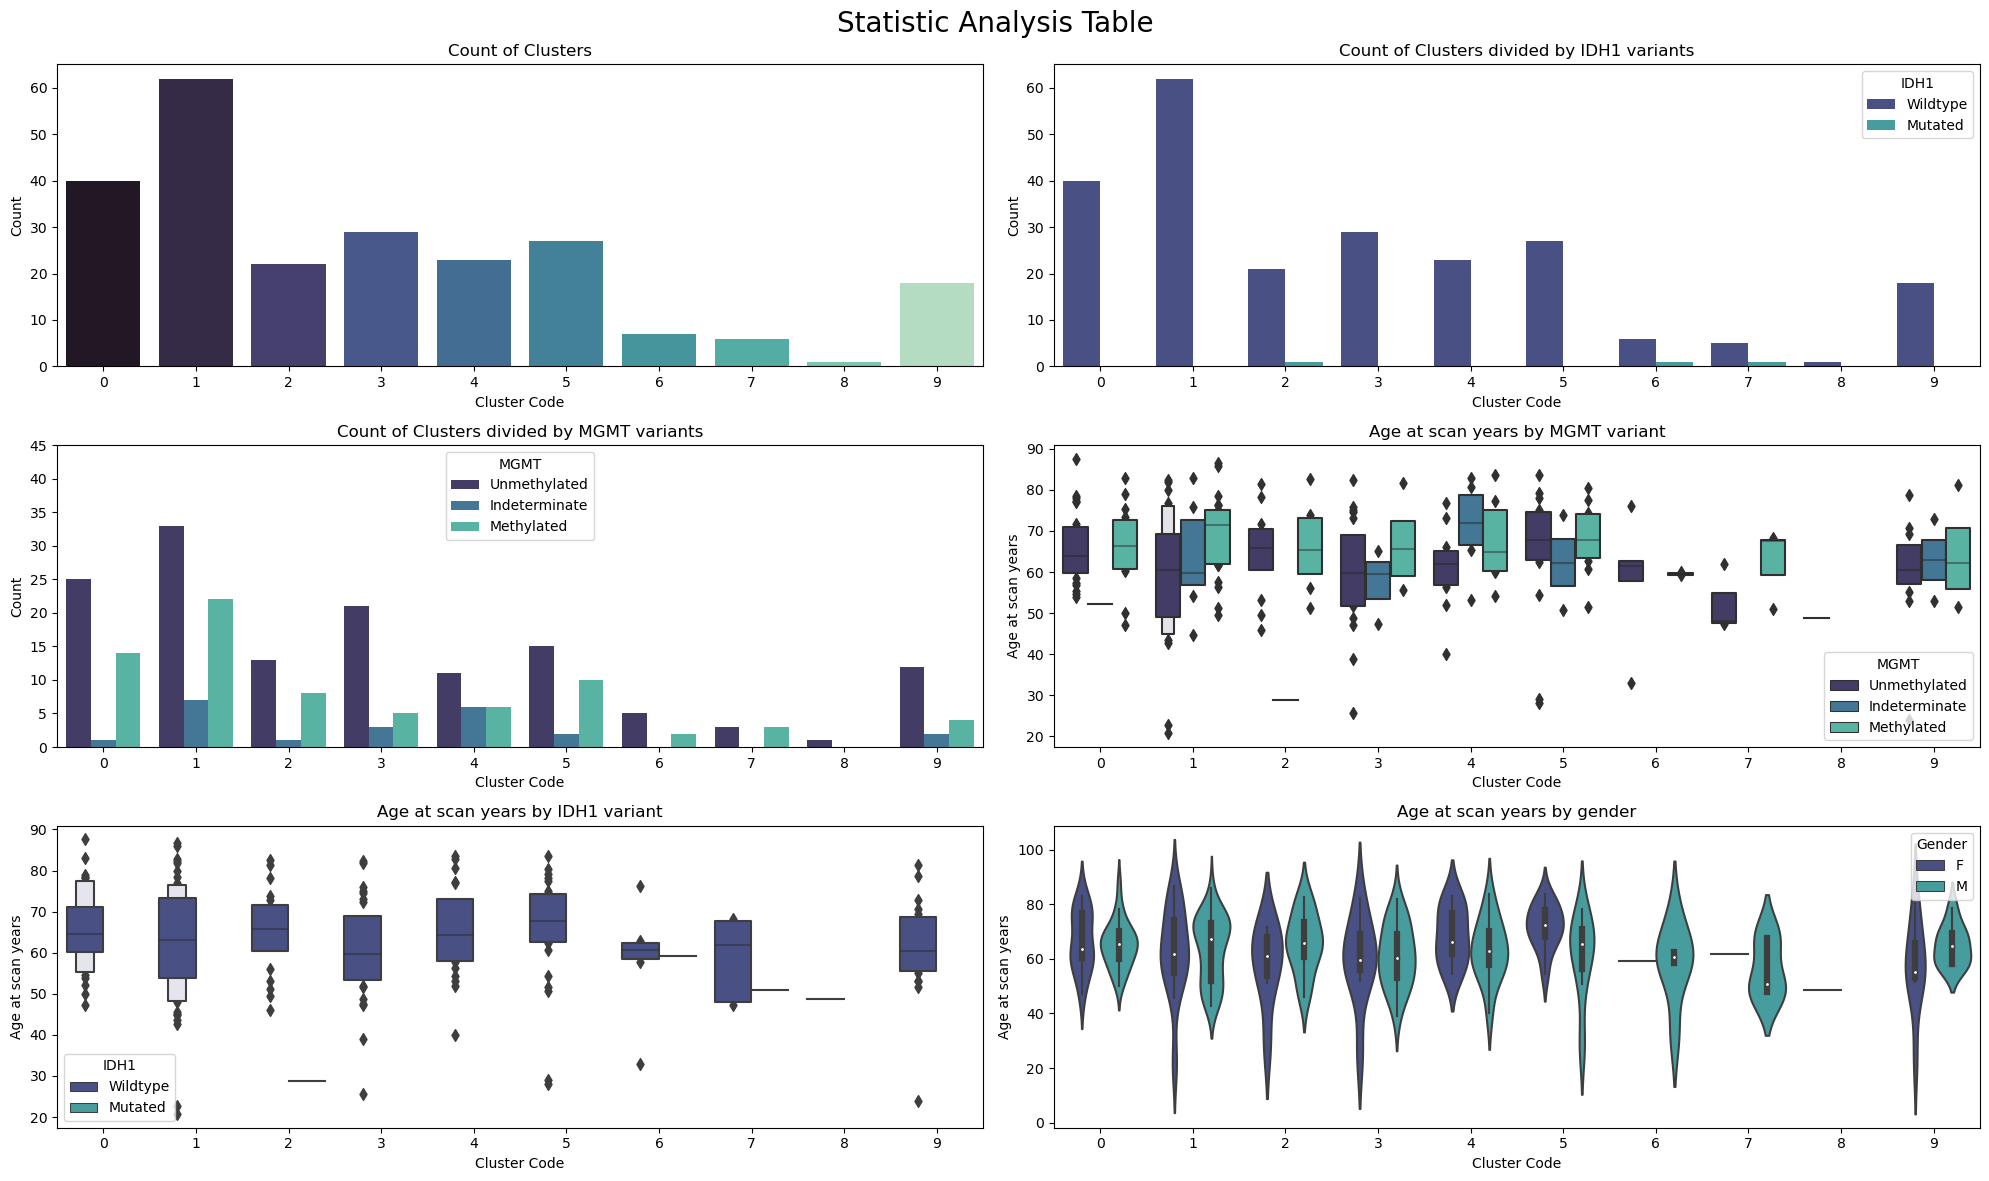

In [267]:
fig3, axs3 = plt.subplots(3,2, figsize=(20,12))

wcss_df = pd.DataFrame(data=reduction_var, columns=['WCSS'])


clusters_count = pd.DataFrame(data = data_results_try['Cluster'].value_counts())
IDH1_categories = pd.DataFrame(data_results_try['IDH1'].value_counts())
MGMT_categories = pd.DataFrame(data_results_try['MGMT'].value_counts())

sns.barplot(data = clusters_count, x = clusters_count.index , y = clusters_count.iloc[:,0],ax = axs3[0,0], palette = 'mako')
axs3[0,0].set_title("Count of Clusters")
axs3[0,0].set_xlabel("Cluster Code")
axs3[0,0].set_ylabel("Count")

sns.countplot(data = data_results_try, x = "Cluster", hue = "IDH1" ,ax = axs3[0,1], palette = 'mako')
axs3[0,1].set_title("Count of Clusters divided by IDH1 variants")
axs3[0,1].set_xlabel("Cluster Code")
axs3[0,1].set_ylabel("Count")

sns.countplot(data = data_results_try, x = "Cluster", hue = "MGMT" ,ax = axs3[1,0], palette = 'mako')
axs3[1,0].set_title("Count of Clusters divided by MGMT variants")
axs3[1,0].set_xlabel("Cluster Code")
axs3[1,0].set_ylabel("Count")
axs3[1,0].set_ylim(0, 45)

sns.boxenplot(data=data_results_try, x="Cluster" , y = "Age_at_scan_years", hue = "MGMT", ax = axs3[1,1], palette = 'mako')
axs3[1,1].set_title("Age at scan years by MGMT variant")
axs3[1,1].set_xlabel("Cluster Code")
axs3[1,1].set_ylabel("Age at scan years")

sns.boxenplot(data=data_results_try, x="Cluster" , y = "Age_at_scan_years", hue = "IDH1", ax = axs3[2,0], palette = 'mako')
axs3[2,0].set_title("Age at scan years by IDH1 variant")
axs3[2,0].set_xlabel("Cluster Code")
axs3[2,0].set_ylabel("Age at scan years")

sns.violinplot(data=data_results_try, x = "Cluster", y = "Age_at_scan_years", hue ="Gender", ax = axs3[2,1], palette = 'mako')
axs3[2,1].set_title("Age at scan years by gender")
axs3[2,1].set_xlabel("Cluster Code")
axs3[2,1].set_ylabel("Age at scan years")

plt.suptitle("Statistic Analysis Table", fontsize = 20)
plt.tight_layout()
plt.savefig(f"{path_output}finaltables.png", dpi = 1000)

Cluster count without IDH1 "Not Available"


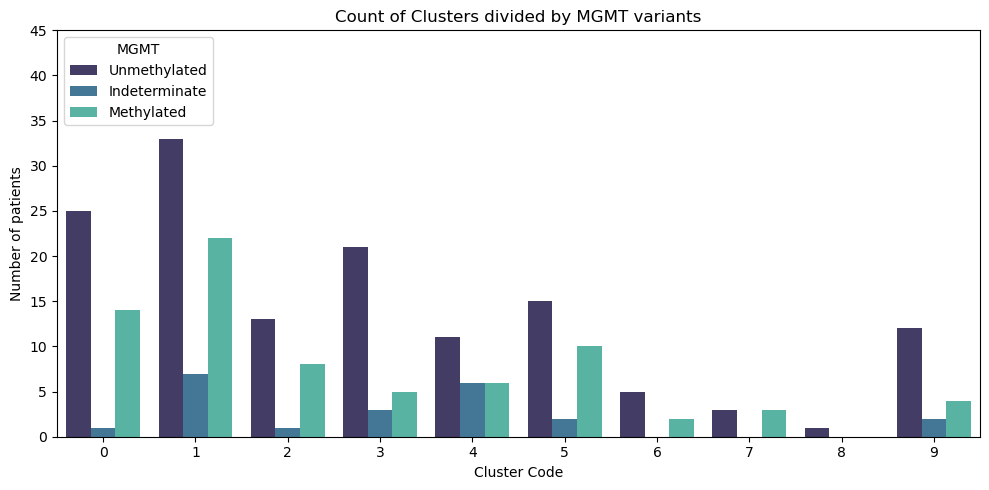

In [268]:
fig4, axs4 = plt.subplots(1,1, figsize = (10, 5))

sns.countplot(data = data_results_try, x = "Cluster", hue = "MGMT", palette = 'mako', ax = axs4)
axs4.set_title("Count of Clusters divided by MGMT variants")
axs4.set_xlabel("Cluster Code")
axs4.set_ylabel("Number of patients")
axs4.set_ylim(0, 45)

plt.tight_layout()
plt.savefig(f"{path_output}countMGMT.png", dpi = 1000)